In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from python.mappings import FOOTBALL_LEAGUES_MAPPING, TEAMS_RANKING_MAPPING, EUROPEAN_TOURNAMENTS_MAPPING

from scipy.stats import norm, skew
from scipy.stats import probplot
from scipy.stats import f_oneway, shapiro, levene, kruskal

from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.svm import SVR, NuSVR
from xgboost import XGBRegressor

from sklearn.metrics import root_mean_squared_error, root_mean_squared_log_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import make_scorer

%matplotlib inline

In [2]:
# Constant variables
TABLE_SIZE = 1546
TRAIN_RATIO = 0.8

In [3]:
# Joins train and test datasets together to simplify the process
def concat_df(df1, df2):
    return pd.concat([df1, df2], ignore_index=True)

# Divides the overall dataset into train and test 
def divide_df(df):
    train_size = int(TABLE_SIZE*TRAIN_RATIO)
    
    return df.loc[:train_size - 1], df.loc[train_size:] 

In [4]:
train_data = pd.read_csv('data/train_stats.csv')
test_data = pd.read_csv('data/test_stats.csv')
all_data = concat_df(train_data, test_data)
df_train, df_test = divide_df(all_data)

**1. PREPARATION STEP: Cleaning the data**

In [5]:
all_data.drop(['Player_URL', 'Team_URL'], axis=1, inplace=True)

In [6]:
# Cleans the columns containing commas 
def clean_comma(column):
    column = column.strip()
    column = column[:column.find(',')] + '' + column[column.find(',') + 1:]
    return column

# Cleans the columns containing '\t' symbol
def clean_tab(column):
    return column.strip().replace('\t', '')

In [7]:
comma_columns = ['Team', 'Position']
tab_columns = ['Goals', 'Assists', 'Yel', 'Red', 'SpG', 'AerialsWon', 'MotM', 'Tackles',
               'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb_x', 'Blocks', 'OwnG', 'KeyP',
               'Drb_y', 'Fouled', 'Off', 'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']

for column in comma_columns:
    all_data[column] = all_data[column].apply(clean_comma)
    
for column in tab_columns:
    all_data[column] = all_data[column].apply(clean_tab)

In [8]:
# Some columns with integer values contain symbol '-' instead of 0. The function fixes it
def remove_dashes(column):
    if column == '-':
        return 0
    return column

In [9]:
dash_columns = ['Goals', 'Assists', 'Yel', 'Red', 'SpG', 'AerialsWon', 'MotM', 'Tackles',
                'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb_x', 'Drb_y', 'Blocks', 'OwnG', 'KeyP',
                'Fouled', 'Off', 'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']

for column in dash_columns:
    all_data[column] = all_data[column].apply(remove_dashes)

In [10]:
# Now we have 'Value' variable containing market values in thousands or millions, but we want to get just an integer
def value_scaling(value):
    value = value.strip()
    
    if value.endswith('k'):
        return int(float(value[value.find('€')+1:value.find('k')]) * 10**3)
    elif value.endswith('m'):
        return int(float(value[value.find('€')+1:value.find('m')]) * 10**6)

In [11]:
all_data['Value'] = all_data['Value'].apply(value_scaling)

In [12]:
# We can divide 'Apps' variable because the number of appearances in starting squad is demonstrated in parentheses 
def appearances_division(apps):
    return apps[:apps.find('(')], apps[apps.find('(')+1:apps.find(')')]

In [13]:
all_data['Overall_Apps'], all_data['Start_Apps'] = zip(*all_data['Apps'].apply(appearances_division))

In [14]:
all_data.drop(['Apps'], axis=1, inplace=True)

In [15]:
# It would be better if we replace 'Forward', 'Midfielder' with their short forms (FW, M)

#all_data['Position'].value_counts()

def position_mapping(position):
    position = position.strip()
    
    if position == 'Forward': 
        return 'FW'
    elif position == 'Midfielder': 
        return 'M(C)'
    return position

all_data['Position'] = all_data['Position'].apply(position_mapping)

In [16]:
# We can divide 'Position' column into two positions (if some player has only one position, he`ll get NaN value for the second one).
def position_division(position):
    
    # only two main positions, that`s enough
    if position.count(',') >= 2:
        while position.count(',') != 1:
            position = position[:position.rfind(',')]
          
    if position.find(',') != -1:
        return pd.Series([position[:position.find(',')].strip(), position[position.find(',')+1:]]).values
    return pd.Series([position.strip(), np.nan]).values

# Center (C), Right (R) or Left (L)? This information is contained in parentheses
def position_side(position):
    
    # np.nan has 'float' type
    if type(position) != float:
        if position.find('(') != -1:
            sides = tuple(position[position.find('(')+1:position.find(')')])
            position = position[:position.find('(')].strip(),
            
            return position + sides + tuple([np.nan] * (3 - len(sides)))
        else:
            position = position.strip(),

            return position + tuple([np.nan] * 3)
    else:
        return tuple([np.nan] * 4)

In [17]:
all_data['Position_1'], all_data['Position_2'] = zip(*all_data['Position'].apply(position_division))

In [18]:
all_data['Position_1'], all_data['Side_11'], all_data['Side_12'], all_data['Side_13'] = zip(*all_data['Position_1'].apply(position_side))
all_data['Position_2'], all_data['Side_21'], all_data['Side_22'], all_data['Side_23'] = zip(*all_data['Position_2'].apply(position_side))

In [19]:
all_data.drop(['Position'], axis=1, inplace=True)

In [20]:
# Time to change column types
float_type = ['SpG', 'AerialsWon', 'Tackles', 'Inter', 'Fouls', 'Offsides',
              'Clear', 'Drb_x', 'Blocks', 'KeyP', 'Drb_y', 'Fouled', 'Off',
              'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']
int_type = ['Goals', 'Assists', 'Yel', 'Red', 'MotM', 'OwnG', 'Overall_Apps', 'Start_Apps']

all_data[float_type] = all_data[float_type].astype('float')
all_data[int_type] = all_data[int_type].astype('int64')

In [21]:
# Insert 'Value' variable at the end of the dataset
value_column = all_data.pop('Value')
all_data['Value'] = value_column

# Insert 'Position_2' variable before the variable 'Side_21'
pos2_column = all_data.pop('Position_2')
index = all_data.columns.get_loc('Side_21')
all_data.insert(index, 'Position_2', pos2_column)

**2. EXPLORATORY DATA ANALYSIS AND FEATURE ENGINEERING**

**GLOSSARY. DESCRIPTION OF THE VARIABLES**

- SpG - Shots per game
- PS(%) - Percentage of successful passes
- AerialsWon, Aerial - Header in a direct contest with an opponent
- MotM - Man of the Match
- Tackle - Dispossessing an opponent, whether the tackling player comes away with the ball or not
- Interception (Inter) - Preventing an opponent's pass from reaching their teammates
- Fouls - How often a player commits a foul
  Fouled - How often a player gets fouled
- Offsides - It`s referred to "offside won" - the last man to step up to catch an opponent in an offside position
  Off - How often a player gets in offside position
- Clearance (Clear) - Action by a defending player that temporarily removes the attacking threat on their goal/that effectively alleviate pressure on their goal
- Drb_x - How often a player gets dribbled (being dribbled past by an opponent without winning a tackle)
  Drb_y - Frequency of successful dribbles
- Blocks - The number of blocked shots per game
- OwnG - Own goal
- KeyP - Key passes (the final pass leading to a shot at goal from a teammate)
- Dispossessed (Disp) - How often a player gets tackled by an opponent without attempting to dribble past them
- UnsTch - ???
- Average Passes (AvgP) - Average number of passes attempted (short passes, long balls, through balls, crosses)
- Cross - An attempted/accurate pass from a wide position to a central attacking area
- Long Ball (LongB) - An attempted/accurate pass of 25 yards or more
- Through Ball (ThrB) - An attempted/accurate pass between opposition players in their defensive line to find an onrushing teammate (running through on goal)
- Apps - appearances on the football field

In [22]:
df_train, df_test = divide_df(all_data)

In [1256]:
#all_data.info()

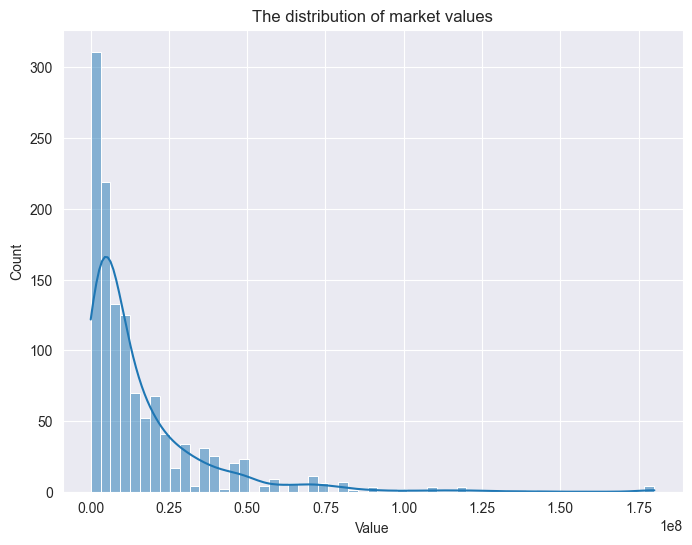

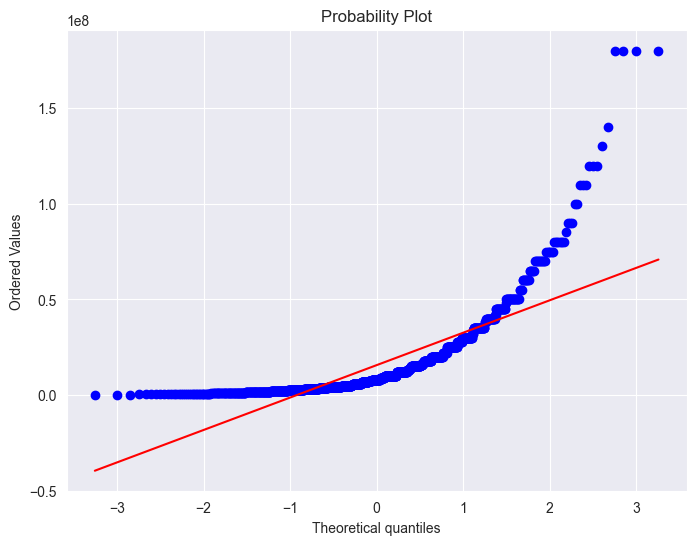

In [1402]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(df_train,
            x='Value',
            kde=True,
            ax=ax)

ax.set_title('The distribution of market values')
ax.set_xlabel('Value')

# QQ-plot
fig = plt.figure(figsize=(8, 6))
res = probplot(df_train['Value'], plot=plt)

plt.show()

In [23]:
df_train['Value'] = np.log1p(df_train['Value'].values)

C:\Users\aleks\AppData\Local\Temp\ipykernel_18776\3785442868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Value'] = np.log1p(df_train['Value'].values)


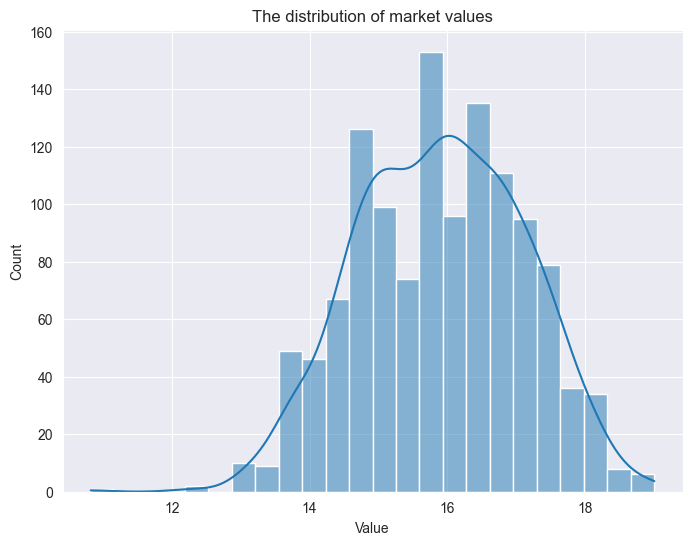

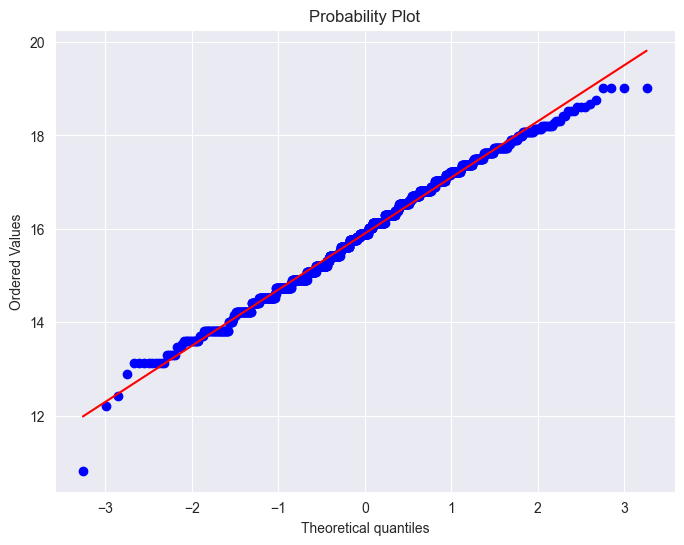

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(df_train,
            x='Value',
            kde=True,
            ax=ax)

ax.set_title('The distribution of market values')
ax.set_xlabel('Value')

# QQ-plot
fig = plt.figure(figsize=(8, 6))
res = probplot(df_train['Value'], plot=plt)

plt.show()

In [25]:
all_data = concat_df(df_train, df_test)

Let`s start with categorical variables.

We see that there are a lot of missing values for 'Side_2X' and 'Side_13' variables (>80%). It describes where a player is located on a football pinch (left, right or center). But it can be useful to create a variable that shows how much place some player "occupies", on how many sides he is able to play. If it isn`t shown (all three variables are NaN values), then we will set 1.

In [26]:
def position_sides(s1, s2, s3):
    sides_list = [s1, s2, s3]
    
    while np.nan in sides_list:
        sides_list.remove(np.nan)
    
    if len(sides_list) == 0:
        return 1
    return len(sides_list)

In [27]:
all_data['Position_1_Sides'] = all_data.apply(lambda x: position_sides(x['Side_11'], x['Side_12'], x['Side_13']), axis=1)
all_data['Position_2_Sides'] = all_data.apply(lambda x: position_sides(x['Side_21'], x['Side_22'], x['Side_23']), axis=1)

Other variables have no missing values so we can continue in our research

'Team' variable can be very useful: we can extract a league in which a football player competes, and it is somehow influences his market value. For instance, we expect that in Premier League players cost more because of higher level of this championship and some other aspects. For this task we will use our mapping.

Also, we can divide our teams into three groups (A, B, C) based on their level ranking. Perhaps, players from "big teams" are more expensive 

In [28]:
all_data['League'] = all_data['Team'].map(FOOTBALL_LEAGUES_MAPPING)
all_data['Team_rank'] = all_data['Team'].map(TEAMS_RANKING_MAPPING)
all_data['European tournament'] = all_data['Team'].map(EUROPEAN_TOURNAMENTS_MAPPING)

Let`s check our presumptions by creating some plots!

In [29]:
order_rank = ['A-tier', 'B-tier', 'C-tier']

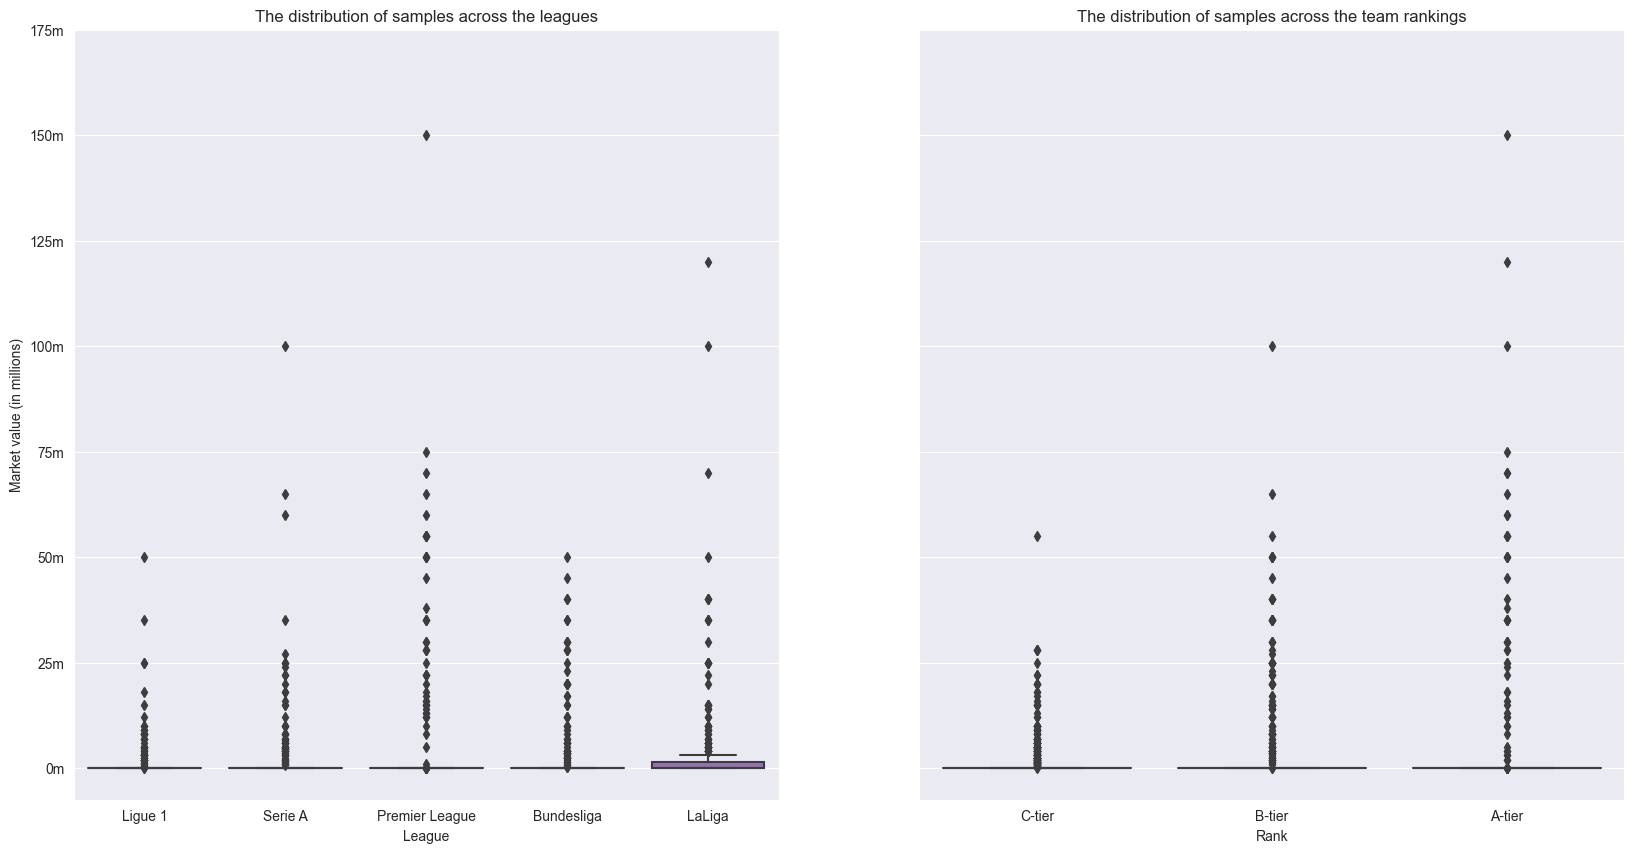

In [1435]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

sns.boxplot(all_data,
            x='League',
            y='Value',
            ax=ax[0])

sns.boxplot(all_data,
            x='Team_rank',
            y='Value',
            order=reversed(order_rank),
            ax=ax[1])

ax[0].set_title('The distribution of samples across the leagues')
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_title('The distribution of samples across the team rankings')
ax[1].set_xlabel('Rank')
ax[1].set_ylabel('')

plt.show()

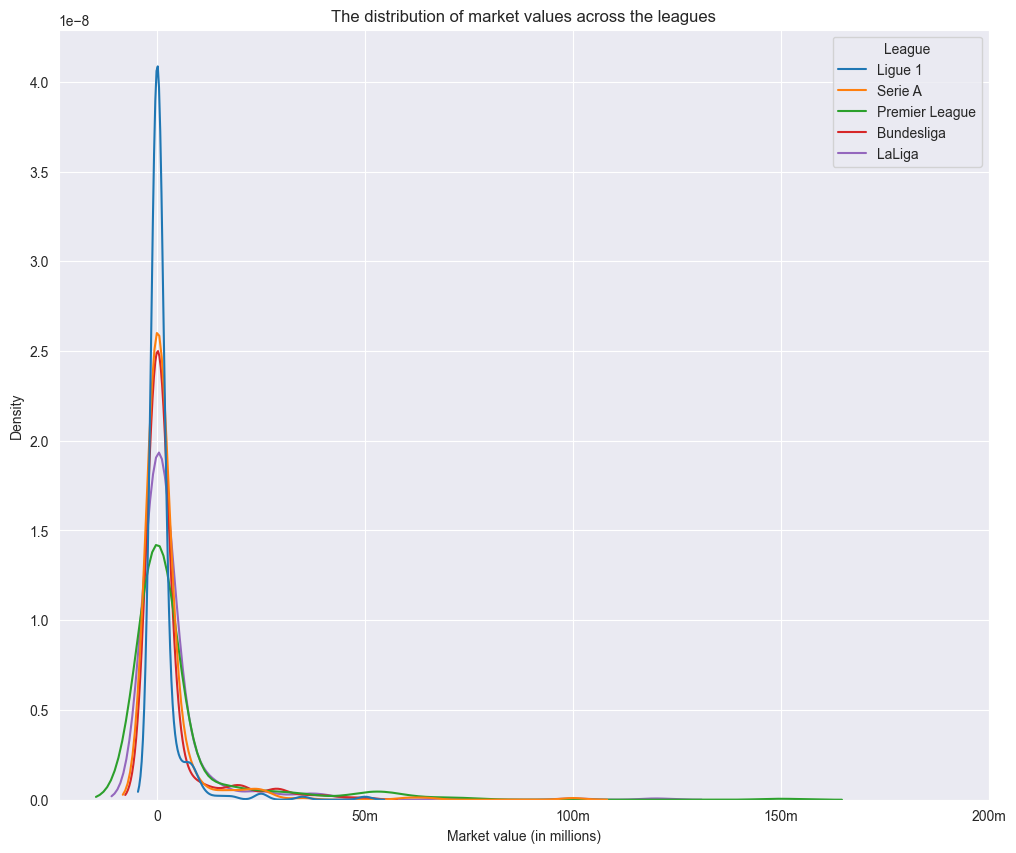

In [1436]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='League')

ax.set_title('The distribution of market values across the leagues')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

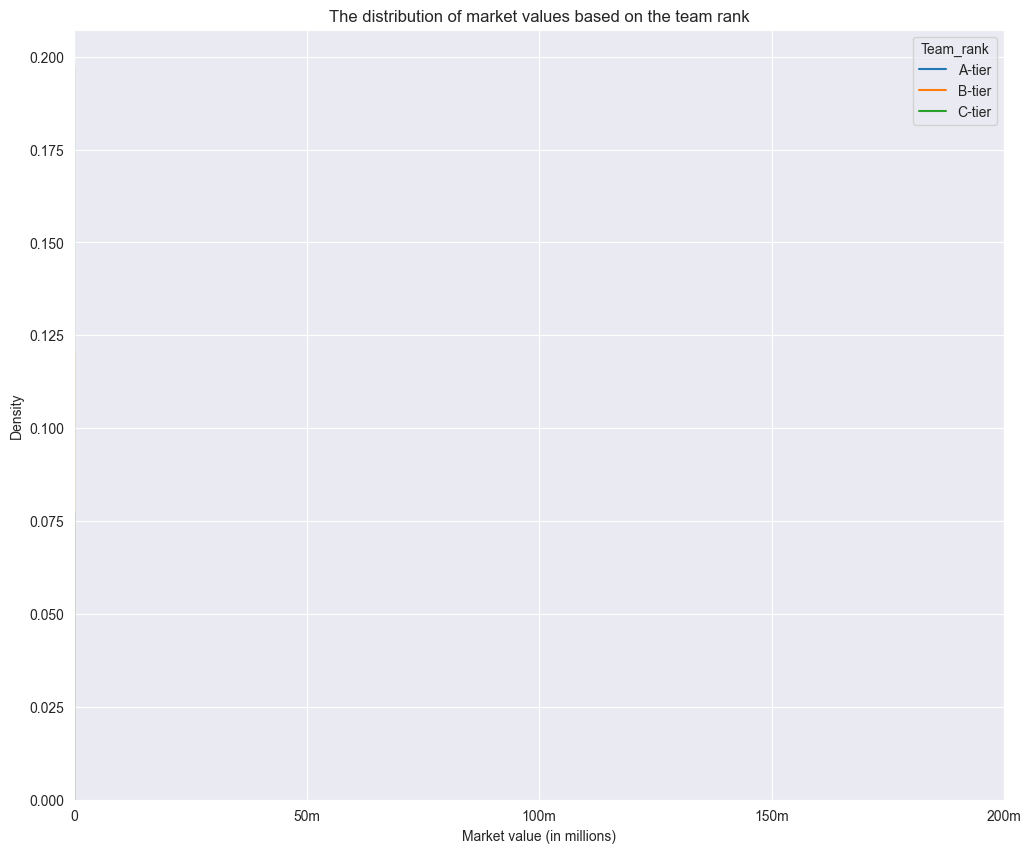

In [1267]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='Team_rank',
            hue_order=order_rank)

ax.set_title('The distribution of market values based on the team rank')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

C:\Users\aleks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:3544: UserWarning: 65.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\aleks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:3544: UserWarning: 66.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\aleks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:3544: UserWarning: 69.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\aleks\AppData\Local\Packages\Py

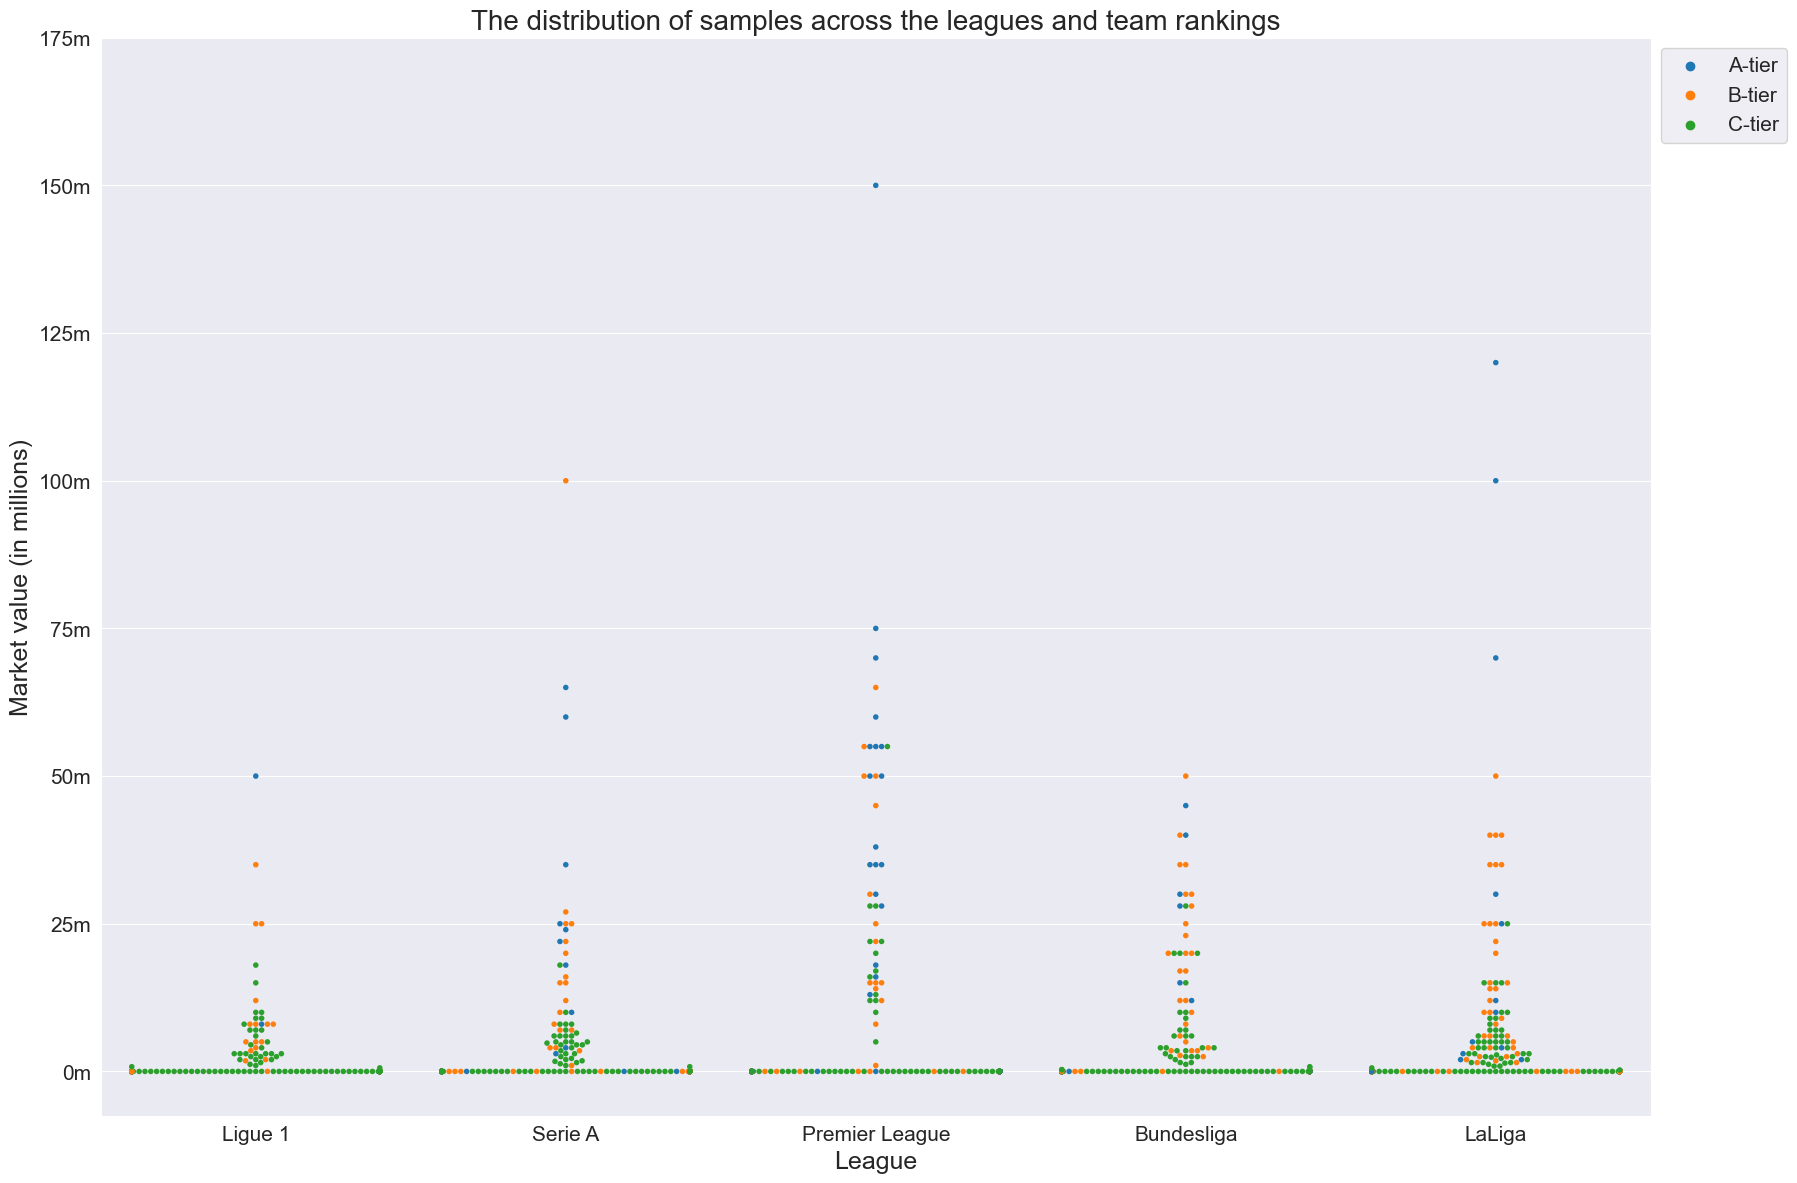

In [1437]:
fig, ax = plt.subplots(figsize=(20, 14))

sns.swarmplot(all_data,
              x='League',
              y='Value',
              size=4,
              hue='Team_rank',
              hue_order=order_rank,
              ax=ax)

ax.set_title('The distribution of samples across the leagues and team rankings', fontsize=20)
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)', fontsize=18)
ax.xaxis.label.set_size(18)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(bbox_to_anchor=(1, 1), loc=2, fontsize=15)

plt.show()

On the first graph we can see that the distributions are almost the same across the leagues, but the Premier league has a little bit different one with higher market values than for other leagues.

From the second one we can notice that the distributions for A-ranked and B-ranked clubs are more heavy-tailed than for C-ranked teams, and in general, the majority of players in "small clubs" are located on the left part of the graph.

In [1438]:
# Creates a table with different descriptive statistics for different groups of a categorical variable 
def descriptive_table(table, variable):
    indices=table.groupby(variable)['Value'].mean().index
    counts = table.groupby(variable)['Value'].count().values
    means = table.groupby(variable)['Value'].mean().values
    stds = table.groupby(variable)['Value'].std().values
    medians = table.groupby(variable)['Value'].median().values
    quantile_ninty = table.groupby(variable)['Value'].quantile(q=0.9).values
    
    table =  pd.DataFrame({'Sample size': counts,
                           'Mean': means,
                           'St. deviation': stds,
                           'Median': medians,
                           '90% quantile': quantile_ninty
                           }, index=indices)
    return table    

In [1439]:
for item in ['League', 'Team_rank']:
    print(f"Variable: {item}")
    display(descriptive_table(all_data, item))

Variable: League


,Sample size,Mean,St. deviation,Median,90% quantile
League,,,,,
Bundesliga,296,2.841229e+06,7.975292e+06,16.118096,9500000.0
LaLiga,329,3.553051e+06,1.165184e+07,16.300417,9000000.0
Ligue 1,284,1.311281e+06,4.748016e+06,16.065415,3350000.0
Premier League,314,4.936320e+06,1.548499e+07,17.034386,16000000.0
Serie A,323,2.302180e+06,8.740644e+06,16.118096,5800000.0


Variable: Team_rank


,Sample size,Mean,St. deviation,Median,90% quantile
Team_rank,,,,,
A-tier,252,6.924617e+06,1.963020e+07,17.504390,28000000.0
B-tier,490,3.898584e+06,1.059061e+07,16.705882,15000000.0
C-tier,804,1.269478e+06,4.073875e+06,15.607270,4000000.0


**Idea**: We can create a variable that indicates whether some footballer plays in Premier League instead of 'League' column

In [30]:
all_data['From EPL'] = all_data['League'] == 'Premier League'

Now we will work with positions. It can be very useful to divide player`s positions into four groups (attack, midfield, defence and goalkeeper) because we can expect that the players in attack line cost more than goalkeepers. We will only operate with the main position and create 'Position' column.

In [31]:
position_mapping = {'FW': 'Attack',
                    'AM': 'Midfield',
                    'M': 'Midfield',
                    'DMC': 'Midfield',
                    'D': 'Defence',
                    'GK': 'Goalkeeper'}

all_data['Position'] = all_data['Position_1'].map(position_mapping)

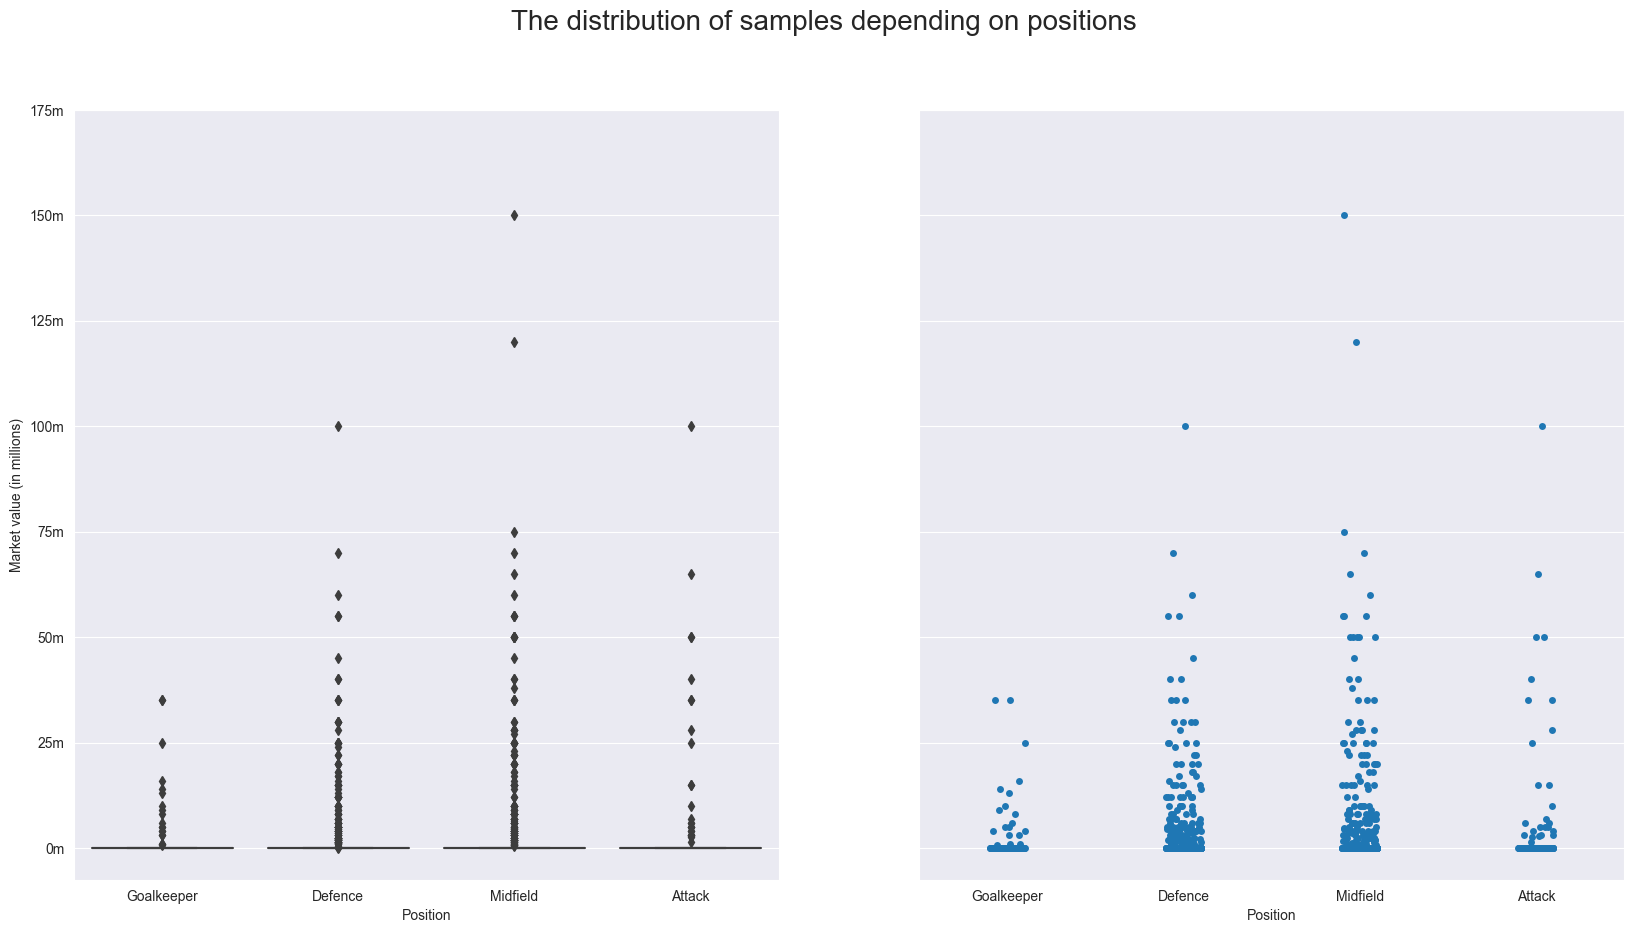

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

position_rank = ['Goalkeeper', 'Defence', 'Midfield', 'Attack']

sns.boxplot(all_data,
            x='Position',
            y='Value',
            order=position_rank,
            ax=ax[0])

sns.stripplot(all_data,
              x='Position',
              y='Value',
              order=position_rank,
              ax=ax[1])

fig.suptitle('The distribution of samples depending on positions', fontsize=20)
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_ylabel('')

plt.show()

In [1274]:
display(descriptive_table(all_data, 'Position'))

,Sample size,Mean,St. deviation,Median,90% quantile
Position,,,,,
Attack,111,15.846350,1.219747,15.607270,17.504390
Defence,618,15.782569,1.193461,15.830414,17.370859
Goalkeeper,94,15.672058,1.139741,15.607270,17.147715
Midfield,723,16.023991,1.201617,16.012735,17.622173


In [1275]:
# Significance test for some categorical variable
def significance_test(variable, transformation=False, test_type=None):
    groups = []

    for group in all_data[variable].unique():
        sample = all_data.query(variable + '== @group')['Value'].values
        
        if transformation == 'log': 
            sample = np.log(sample + 1)
        elif transformation == 'sqrt': 
            sample = np.sqrt(np.abs(sample))
            
        print(f'Shapiro-Wilk test: {shapiro(sample)}')
        groups.append(sample)

    print(f'Levene: {levene(*groups)}')
    
    if test_type == 'anova':
        print(f'ANOVA test: {f_oneway(*groups)}')
    elif test_type == 'kruskal':
        for g in groups:
            np.sort(g)
            
        print(f'Kruskal-Wallis test: {kruskal(*groups)}')

In [1276]:
significance_test('Position')

Shapiro-Wilk test: ShapiroResult(statistic=0.9911483603510157, pvalue=0.00025009395067626433)
Shapiro-Wilk test: ShapiroResult(statistic=0.9638427394140349, pvalue=0.010609204782735901)
Shapiro-Wilk test: ShapiroResult(statistic=0.9810127009464324, pvalue=0.11544302038132292)
Shapiro-Wilk test: ShapiroResult(statistic=0.9908761008326488, pvalue=0.0007225419010297908)
Levene: LeveneResult(statistic=0.23173730875181117, pvalue=0.8743134437741662)


The samples aren`t distributed normally and their variances differ significantly, but we can use transformations

In [1277]:
for tr in ['log', 'sqrt']:
    significance_test('Position', transformation=tr)
    print()
    print('=' * 25)
    print()

Shapiro-Wilk test: ShapiroResult(statistic=0.9886509027219519, pvalue=2.176981014897649e-05)
Shapiro-Wilk test: ShapiroResult(statistic=0.9590163318046697, pvalue=0.004924518843554594)
Shapiro-Wilk test: ShapiroResult(statistic=0.984528786954418, pvalue=0.2292885346769712)
Shapiro-Wilk test: ShapiroResult(statistic=0.9832326933708778, pvalue=1.5647826660179044e-06)
Levene: LeveneResult(statistic=0.09096992164884701, pvalue=0.9650285168634521)


Shapiro-Wilk test: ShapiroResult(statistic=0.9902116613319372, pvalue=9.711617874299904e-05)
Shapiro-Wilk test: ShapiroResult(statistic=0.9615989364889229, pvalue=0.007401063567792357)
Shapiro-Wilk test: ShapiroResult(statistic=0.9832469880347182, pvalue=0.17910691138638535)
Shapiro-Wilk test: ShapiroResult(statistic=0.9875458935103635, pvalue=4.0652647920096355e-05)
Levene: LeveneResult(statistic=0.1396717780208536, pvalue=0.9362704355200295)




The samples` distribution is still abnormal, but their variances are homogenous, so we can try to use Kruskal-Wallis test (we cannot use ANOVA test)

In [1278]:
print('Without transformation: ')
significance_test('Position', transformation=False, test_type='kruskal')

Without transformation: 
Shapiro-Wilk test: ShapiroResult(statistic=0.9911483603510157, pvalue=0.00025009395067626433)
Shapiro-Wilk test: ShapiroResult(statistic=0.9638427394140349, pvalue=0.010609204782735901)
Shapiro-Wilk test: ShapiroResult(statistic=0.9810127009464324, pvalue=0.11544302038132292)
Shapiro-Wilk test: ShapiroResult(statistic=0.9908761008326488, pvalue=0.0007225419010297908)
Levene: LeveneResult(statistic=0.23173730875181117, pvalue=0.8743134437741662)
Kruskal-Wallis test: KruskalResult(statistic=15.038079641393859, pvalue=0.0017843947425119037)


In [1279]:
print('With log transformation: ')
significance_test('Position', transformation='log', test_type='kruskal')

With log transformation: 
Shapiro-Wilk test: ShapiroResult(statistic=0.9886509027219519, pvalue=2.176981014897649e-05)
Shapiro-Wilk test: ShapiroResult(statistic=0.9590163318046697, pvalue=0.004924518843554594)
Shapiro-Wilk test: ShapiroResult(statistic=0.984528786954418, pvalue=0.2292885346769712)
Shapiro-Wilk test: ShapiroResult(statistic=0.9832326933708778, pvalue=1.5647826660179044e-06)
Levene: LeveneResult(statistic=0.09096992164884701, pvalue=0.9650285168634521)
Kruskal-Wallis test: KruskalResult(statistic=15.038079641393859, pvalue=0.0017843947425119037)


Since Kruskal-Wallis test shows significant result, we can leave this variable

Let`s check 'Side_11' variable because it is footballer's main side (location where he usually plays)

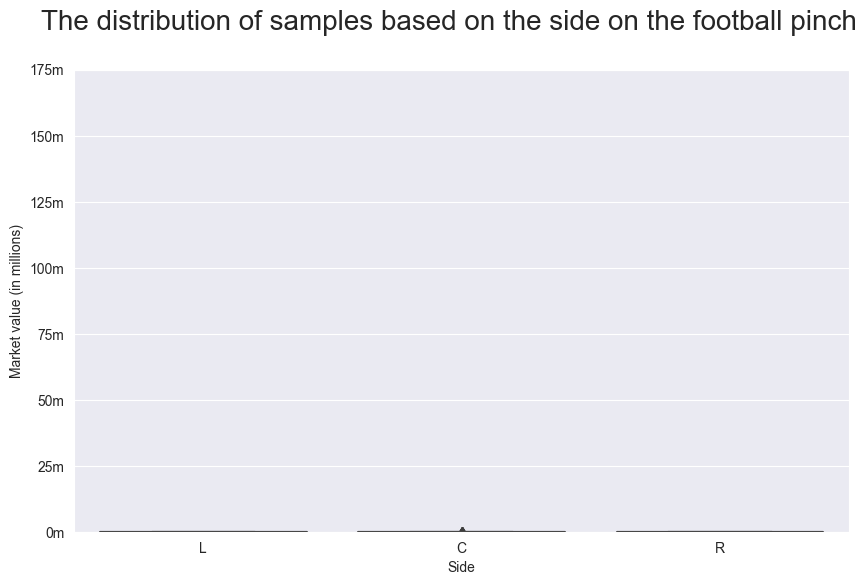

In [1280]:
fig, ax = plt.subplots(figsize=(10, 6))

side_rank = ['L', 'C', 'R']

sns.boxplot(all_data,
            x='Side_11',
            y='Value',
            order=side_rank,
            ax=ax)

fig.suptitle('The distribution of samples based on the side on the football pinch', fontsize=20)
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')
ax.set_xlabel('Side')

plt.show()

In [1281]:
descriptive_table(all_data, 'Side_11')

,Sample size,Mean,St. deviation,Median,90% quantile
Side_11,,,,,
C,881,15.967765,1.232721,16.012735,17.553180
L,237,15.838808,1.210313,15.830414,17.370859
R,115,15.680443,1.036205,15.607270,17.034386


In [33]:
all_data['Side_11'].fillna(all_data['Side_11'].mode().values[0], inplace=True)
#all_data['Side_11'] = all_data.groupby('Position')['Side_11'].transform(lambda x: x.fillna(x.mode()))

In [34]:
all_data.rename(columns={'Side_11': 'Main side'}, inplace=True)

This variable is not so useful as the previous ones. There are too little data for Left and Right sides, and we can expect that 'Side_12', 'Side_13', etc. are even less informative, so in the future we can drop them, leaving only 'Main_side' (it is the same as 'Side_11') variable.

Now we will work with 'Position_1_Sides' and 'Position_2_Sides' and create some interesting (at least we hope) plots

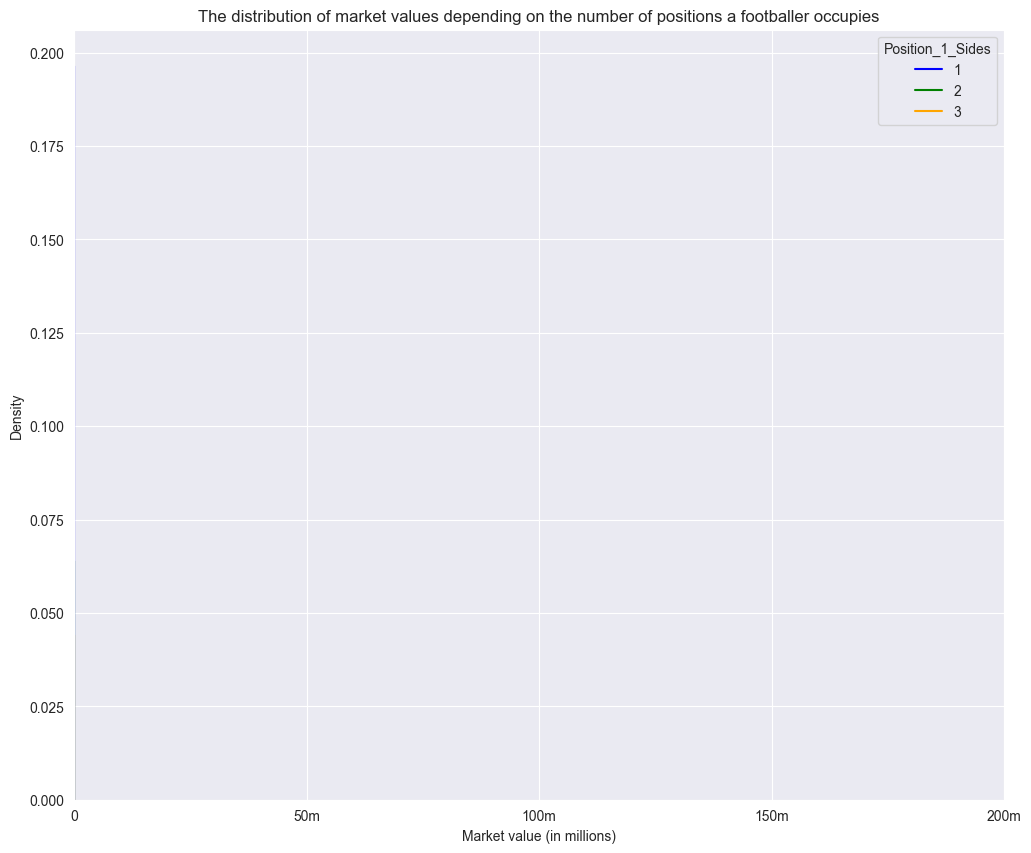

In [1284]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='Position_1_Sides',
            palette=['blue', 'green', 'orange'])

ax.set_title('The distribution of market values depending on the number of positions a footballer occupies')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

Now let`s work with numerical variables  

In [1285]:
all_data.describe()

,Age,Mins,Goals,Assists,Yel,Red,SpG,PS,AerialsWon,MotM,...,UnsTch,AvgP,Crosses,LongB,ThrB,Overall_Apps,Start_Apps,Value,Position_1_Sides,Position_2_Sides
count,1546.000000,1546.000000,1546.000000,1546.000000,1546.00000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,...,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000
mean,26.873868,1918.762613,2.850582,2.004528,3.93467,0.174644,0.894825,80.035511,0.962678,1.038163,...,0.991074,31.006468,0.301035,1.638616,0.040621,17.393920,7.135834,15.893332,1.563389,1.077620
std,4.115202,706.446517,3.931821,2.298863,2.68333,0.415591,0.692623,7.927905,0.852841,1.464300,...,0.654077,16.395636,0.413790,1.662868,0.070546,9.582248,5.527306,1.201548,0.770948,0.328462
min,16.000000,195.000000,0.000000,0.000000,0.00000,0.000000,0.000000,44.900000,0.000000,0.000000,...,0.000000,3.600000,0.000000,0.000000,0.000000,0.000000,1.000000,10.819798,1.000000,1.000000
25%,24.000000,1376.250000,0.000000,0.000000,2.00000,0.000000,0.400000,75.700000,0.400000,0.000000,...,0.500000,18.525000,0.000000,0.500000,0.000000,10.000000,3.000000,14.914123,1.000000,1.000000
50%,27.000000,1913.000000,1.000000,1.000000,4.00000,0.000000,0.700000,81.100000,0.700000,1.000000,...,0.900000,28.800000,0.100000,1.100000,0.000000,18.000000,5.000000,15.894952,1.000000,1.000000
75%,30.000000,2485.000000,4.000000,3.000000,5.00000,0.000000,1.275000,85.600000,1.300000,2.000000,...,1.400000,40.700000,0.400000,2.200000,0.100000,25.000000,11.000000,16.811243,2.000000,1.000000
max,40.000000,3420.000000,36.000000,14.000000,17.00000,3.000000,4.600000,95.400000,6.800000,10.000000,...,3.700000,106.900000,2.900000,15.400000,0.600000,37.000000,28.000000,19.008467,3.000000,3.000000


In [35]:
df_train, df_test = divide_df(all_data)

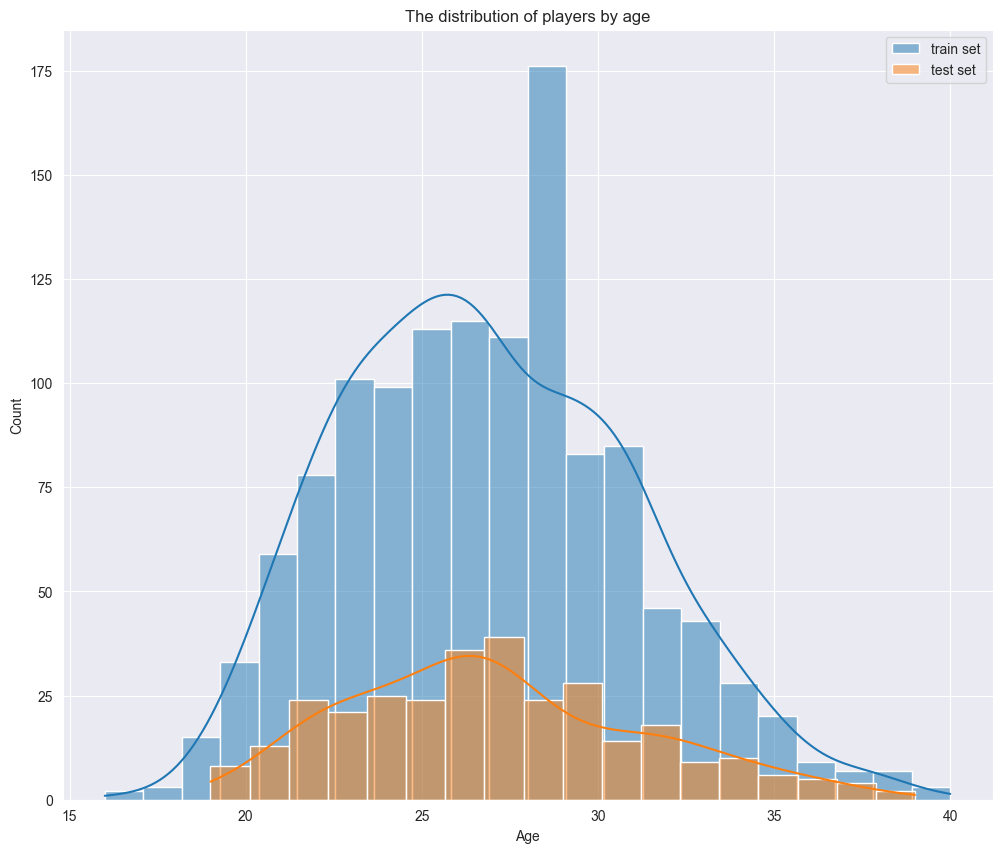

In [1287]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.histplot(df_train,
            x='Age',
            kde=True,
            ax=ax,
            label='train set')

sns.histplot(df_test,
            x='Age',
            kde=True,
            bins=18,
            ax=ax,
            label='test set')

ax.set_title('The distribution of players by age')
ax.set_xlabel('Age')
ax.legend()

plt.show()

In [36]:
all_data['Age'] = pd.cut(all_data['Age'], bins=4)

In [37]:
df_train, df_test = divide_df(all_data)

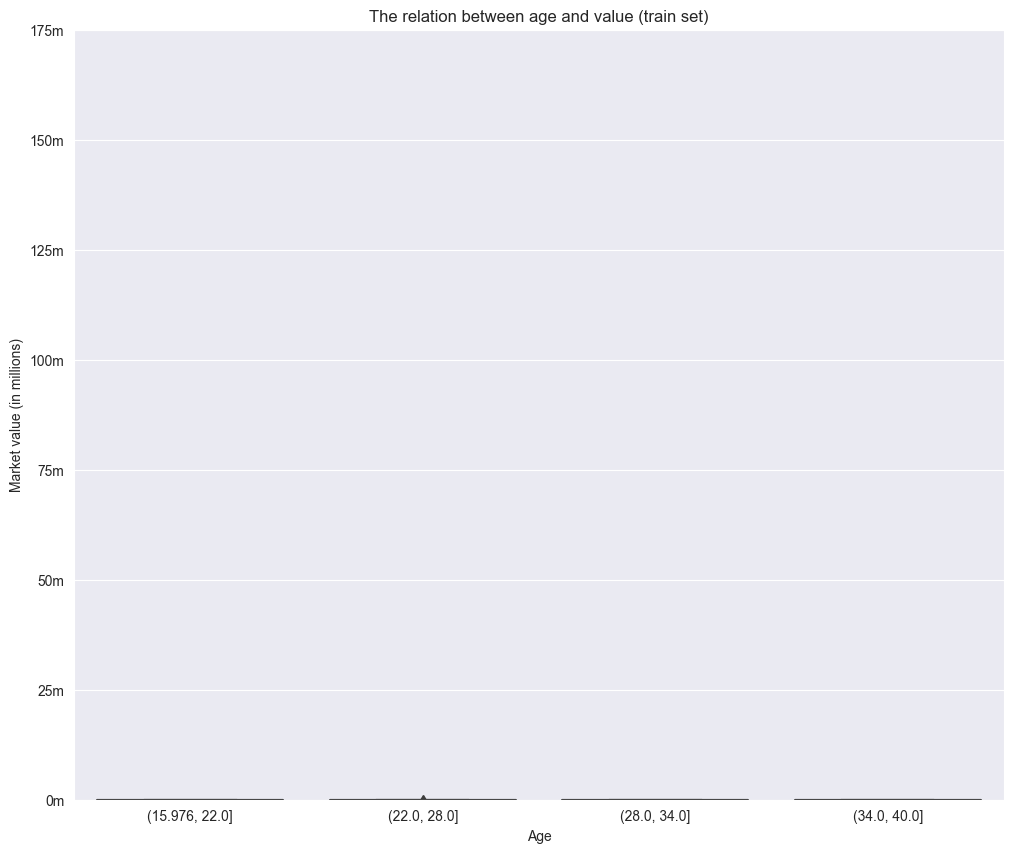

In [1290]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.boxplot(df_train,
            x='Age',
            y='Value',
            ax=ax)

ax.set_title('The relation between age and value (train set)')
ax.set_xlabel('Age')
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')

plt.show()

In [1291]:
descriptive_table(df_train, 'Age')

,Sample size,Mean,St. deviation,Median,90% quantile
Age,,,,,
"(15.976, 22.0]",190,16.360763,1.009538,16.300417,17.622173
"(22.0, 28.0]",619,16.213406,1.110861,16.300417,17.622173
"(28.0, 34.0]",381,15.379342,1.069900,15.201805,16.906553
"(34.0, 40.0]",46,14.061389,0.924601,13.815512,15.424949


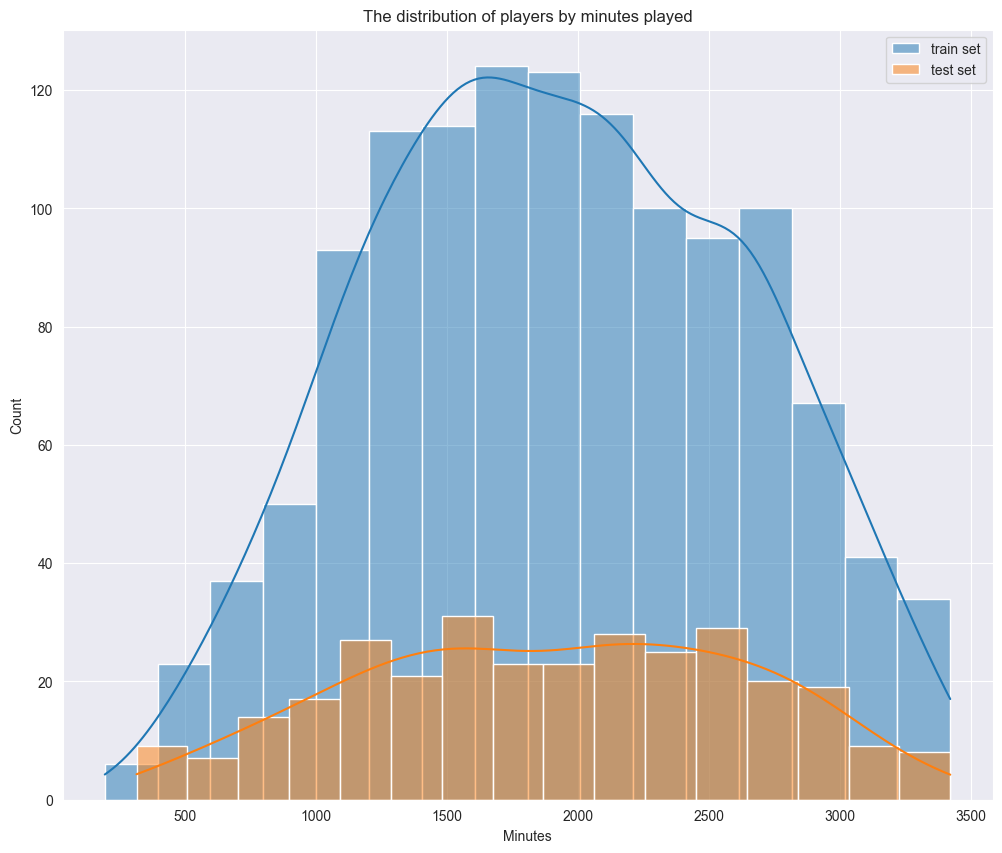

In [1292]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.histplot(df_train,
            x='Mins',
            kde=True,
            ax=ax,
            label='train set')

sns.histplot(df_test,
            x='Mins',
            kde=True,
            bins=16,
            ax=ax,
            label='test set')

ax.set_title('The distribution of players by minutes played')
ax.set_xlabel('Minutes')
ax.legend()

plt.show()

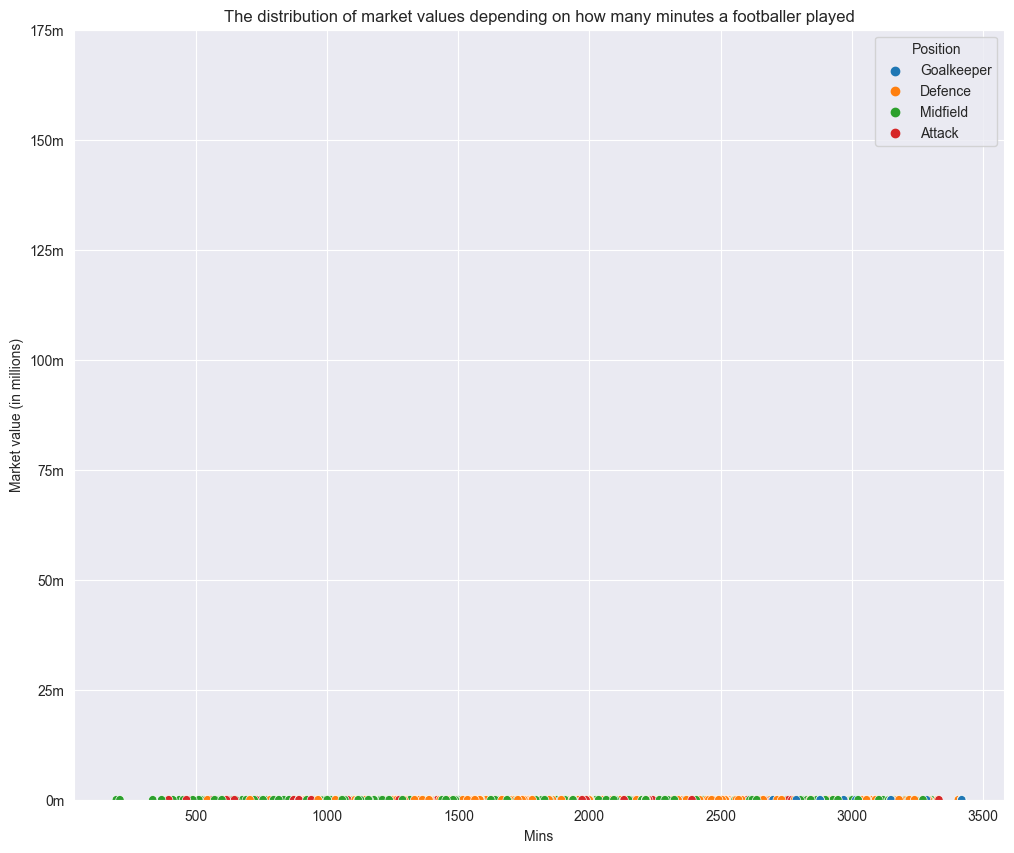

In [1293]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.scatterplot(df_train,
            x='Mins',
            y='Value',
            hue='Position',
            hue_order=position_rank,
            ax=ax)

ax.set_title('The distribution of market values depending on how many minutes a footballer played')
ax.set_xlabel('Mins')
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')

plt.show()

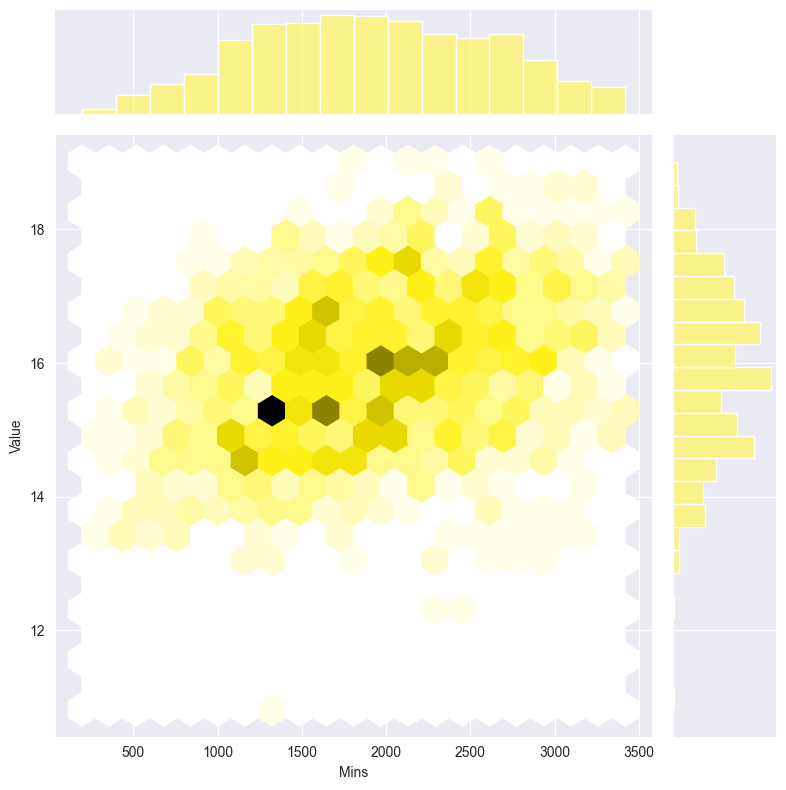

In [1294]:
sns.jointplot(df_train,
              x='Mins',
              y='Value',
              kind="hex", 
              height=8,
              color="#FFF668")

plt.show()

In [1295]:
#all_data['Minutes for MotM'] = all_data['Mins'] / all_data['MotM']
#all_data['Minutes for Goal'] = all_data['Mins'] / all_data['Goals']
#all_data['Minutes for Assist'] = all_data['Mins'] / all_data['Assists']
#all_data['Minutes for KeyP'] = all_data['Mins'] / all_data['KeyP']

In [38]:
all_data['Mins'] = pd.qcut(all_data['Mins'], q=4)
df_train, df_test = divide_df(all_data)

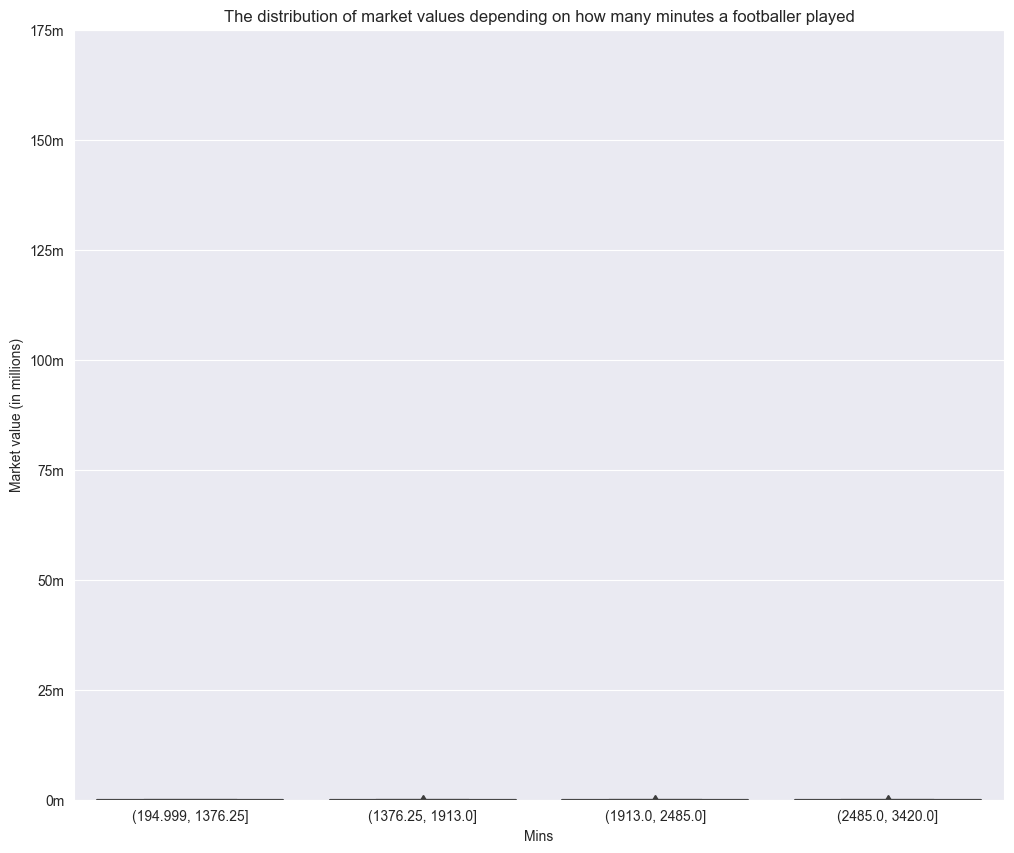

In [1297]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.boxplot(df_train,
            x='Mins',
            y='Value',
            ax=ax)

ax.set_title('The distribution of market values depending on how many minutes a footballer played')
ax.set_xlabel('Mins')
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')

plt.show()

In [1298]:
descriptive_table(df_train, 'Mins')

,Sample size,Mean,St. deviation,Median,90% quantile
Mins,,,,,
"(194.999, 1376.25]",305,15.350721,1.090249,15.201805,16.811243
"(1376.25, 1913.0]",318,15.787684,1.131008,15.761421,17.216708
"(1913.0, 2485.0]",307,16.153676,1.140301,16.118096,17.703040
"(2485.0, 3420.0]",306,16.305114,1.225245,16.380460,17.775189


In [39]:
all_data['Goals'] = pd.cut(all_data['Goals'], bins=4)
all_data['Assists'] = pd.cut(all_data['Assists'], bins=4)

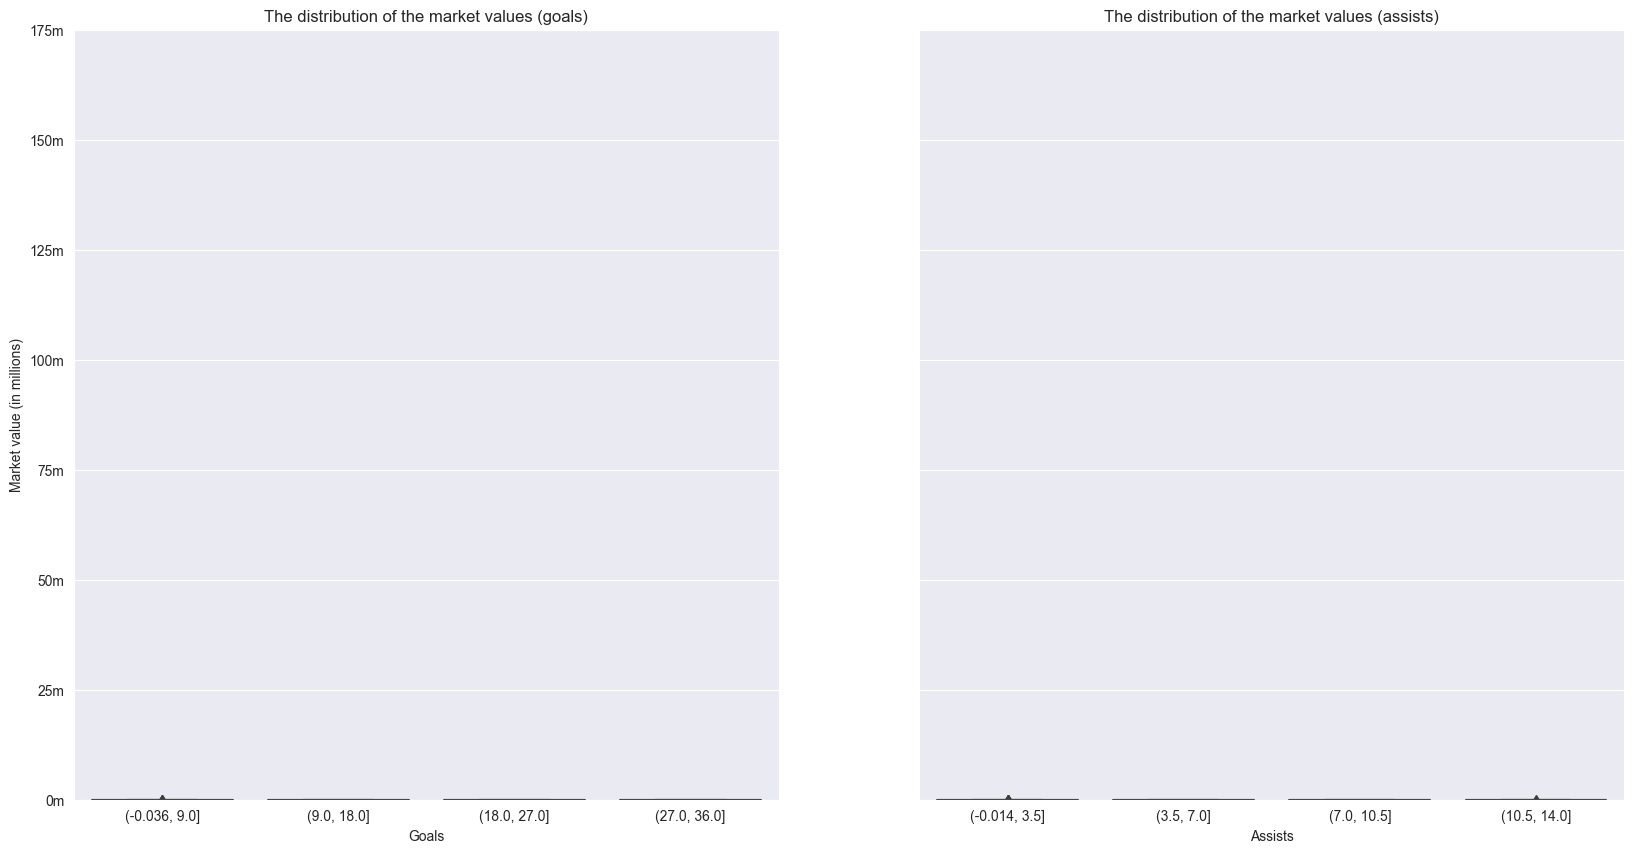

In [1300]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

sns.boxplot(all_data,
            x='Goals',
            y='Value',
            ax=ax[0])

sns.boxplot(all_data,
            x='Assists',
            y='Value',
            ax=ax[1])

ax[0].set_title('The distribution of the market values (goals)')
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_title('The distribution of the market values (assists)')
ax[1].set_ylabel('')

plt.show()

In [1301]:
for item in ['Goals', 'Assists']:
    print(f'Variable: {item}')
    display(descriptive_table(all_data, item))

Variable: Goals


,Sample size,Mean,St. deviation,Median,90% quantile
Goals,,,,,
"(-0.036, 9.0]",1446,15.799538,1.160818,15.830414,17.370859
"(9.0, 18.0]",83,17.111604,0.892269,17.216708,18.064006
"(18.0, 27.0]",15,17.918086,0.915785,17.989898,19.008467
"(27.0, 36.0]",2,17.962535,0.647915,17.962535,18.329052


Variable: Assists


,Sample size,Mean,St. deviation,Median,90% quantile
Assists,,,,,
"(-0.014, 3.5]",1260,15.708793,1.143082,15.761421,17.216708
"(3.5, 7.0]",223,16.542150,1.090411,16.648724,17.822844
"(7.0, 10.5]",53,17.187097,1.036670,17.504390,18.399609
"(10.5, 14.0]",10,17.819639,0.581712,17.949876,18.246088


Let`s drop redundant features or the features with missing values

In [40]:
all_data.drop(['Side_12', 'Side_13', 'Side_21', 'Side_22', 'League', 'Team',
               'Side_23', 'Position_1', 'Position_2', 'Position_2_Sides'], axis=1, inplace=True)

all_data, all_names = all_data.drop('Name', axis=1), all_data['Name']

train_names, test_names = divide_df(all_names) 

In [41]:
all_data.sample(10)

,Age,Mins,Goals,Assists,Yel,Red,SpG,PS,AerialsWon,MotM,...,ThrB,Overall_Apps,Start_Apps,Main side,Value,Position_1_Sides,Team_rank,European tournament,From EPL,Position
1086,"(28.0, 34.0]","(2485.0, 3420.0]","(-0.036, 9.0]","(-0.014, 3.5]",3,0,0.0,69.4,0.3,2,...,0.0,3,3,C,1.630042e+01,1,C-tier,None,True,Goalkeeper
925,"(22.0, 28.0]","(2485.0, 3420.0]","(-0.036, 9.0]","(-0.014, 3.5]",11,0,0.8,83.3,0.5,1,...,0.1,32,2,C,1.737086e+01,1,B-tier,None,True,Midfield
1484,"(22.0, 28.0]","(194.999, 1376.25]","(-0.036, 9.0]","(-0.014, 3.5]",2,0,1.1,73.8,1.1,0,...,0.1,12,8,C,2.800000e+07,1,C-tier,None,True,Attack
647,"(28.0, 34.0]","(1913.0, 2485.0]","(-0.036, 9.0]","(7.0, 10.5]",5,0,0.3,79.7,1.1,3,...,0.0,26,2,L,1.611810e+01,2,B-tier,Champions League,True,Defence
130,"(28.0, 34.0]","(1376.25, 1913.0]","(-0.036, 9.0]","(-0.014, 3.5]",4,0,0.2,84.9,1.1,0,...,0.0,17,10,C,1.611810e+01,2,B-tier,Europa League,True,Defence
13,"(22.0, 28.0]","(1376.25, 1913.0]","(-0.036, 9.0]","(-0.014, 3.5]",5,0,1.0,86.5,0.8,1,...,0.1,17,12,C,1.601274e+01,2,B-tier,None,False,Midfield
1487,"(28.0, 34.0]","(194.999, 1376.25]","(-0.036, 9.0]","(-0.014, 3.5]",1,0,0.6,79.1,0.9,0,...,0.0,9,8,C,2.000000e+06,3,B-tier,Conference League,False,Midfield
1218,"(22.0, 28.0]","(1376.25, 1913.0]","(9.0, 18.0]","(-0.014, 3.5]",2,0,1.8,74.0,0.5,3,...,0.1,19,14,C,1.658810e+01,2,C-tier,None,False,Midfield
599,"(28.0, 34.0]","(2485.0, 3420.0]","(-0.036, 9.0]","(-0.014, 3.5]",4,1,0.2,87.8,1.4,0,...,0.0,30,1,C,1.381551e+01,2,C-tier,None,False,Defence
697,"(22.0, 28.0]","(1376.25, 1913.0]","(-0.036, 9.0]","(-0.014, 3.5]",0,0,1.4,77.4,0.5,0,...,0.0,15,15,C,1.652356e+01,3,C-tier,None,True,Midfield


In [1304]:
def pairplot_creator(table, index_start=0, index_end=40):
    new_table = table.iloc[:, index_start:index_end]
    new_table['Value'] = table['Value']
    
    sns.pairplot(new_table, height=2)
    plt.show()

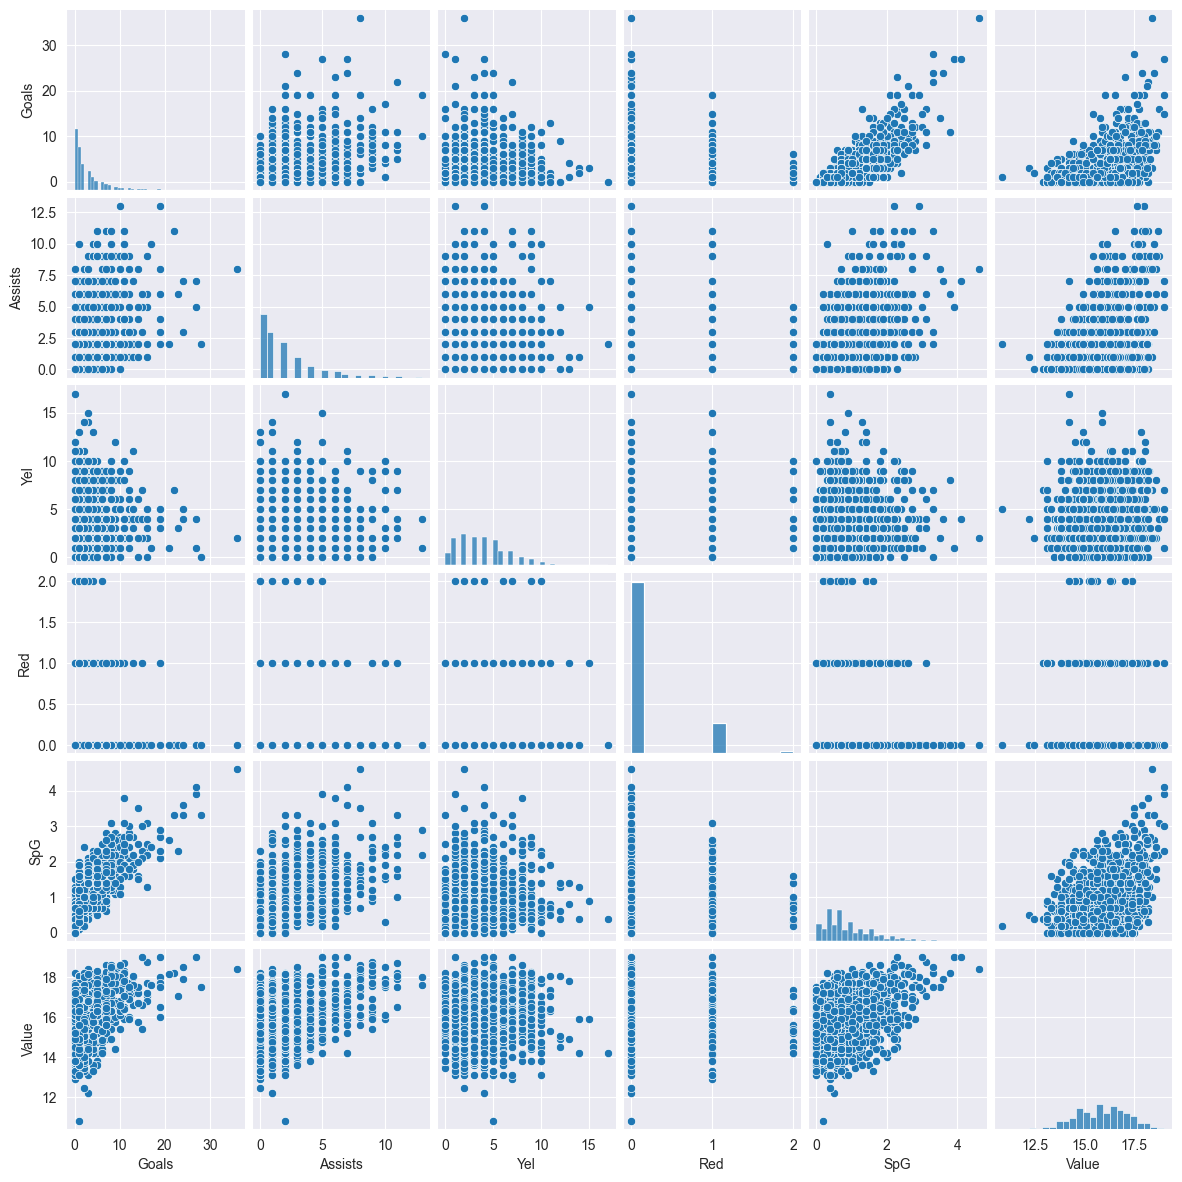

In [1305]:
pairplot_creator(df_train, index_start=4, index_end=9)

In [42]:
# Insert 'Value' variable at the end of the dataset
value_column = all_data.pop('Value')
all_data['Value'] = value_column

In [1307]:
df_train, df_test = divide_df(all_data)

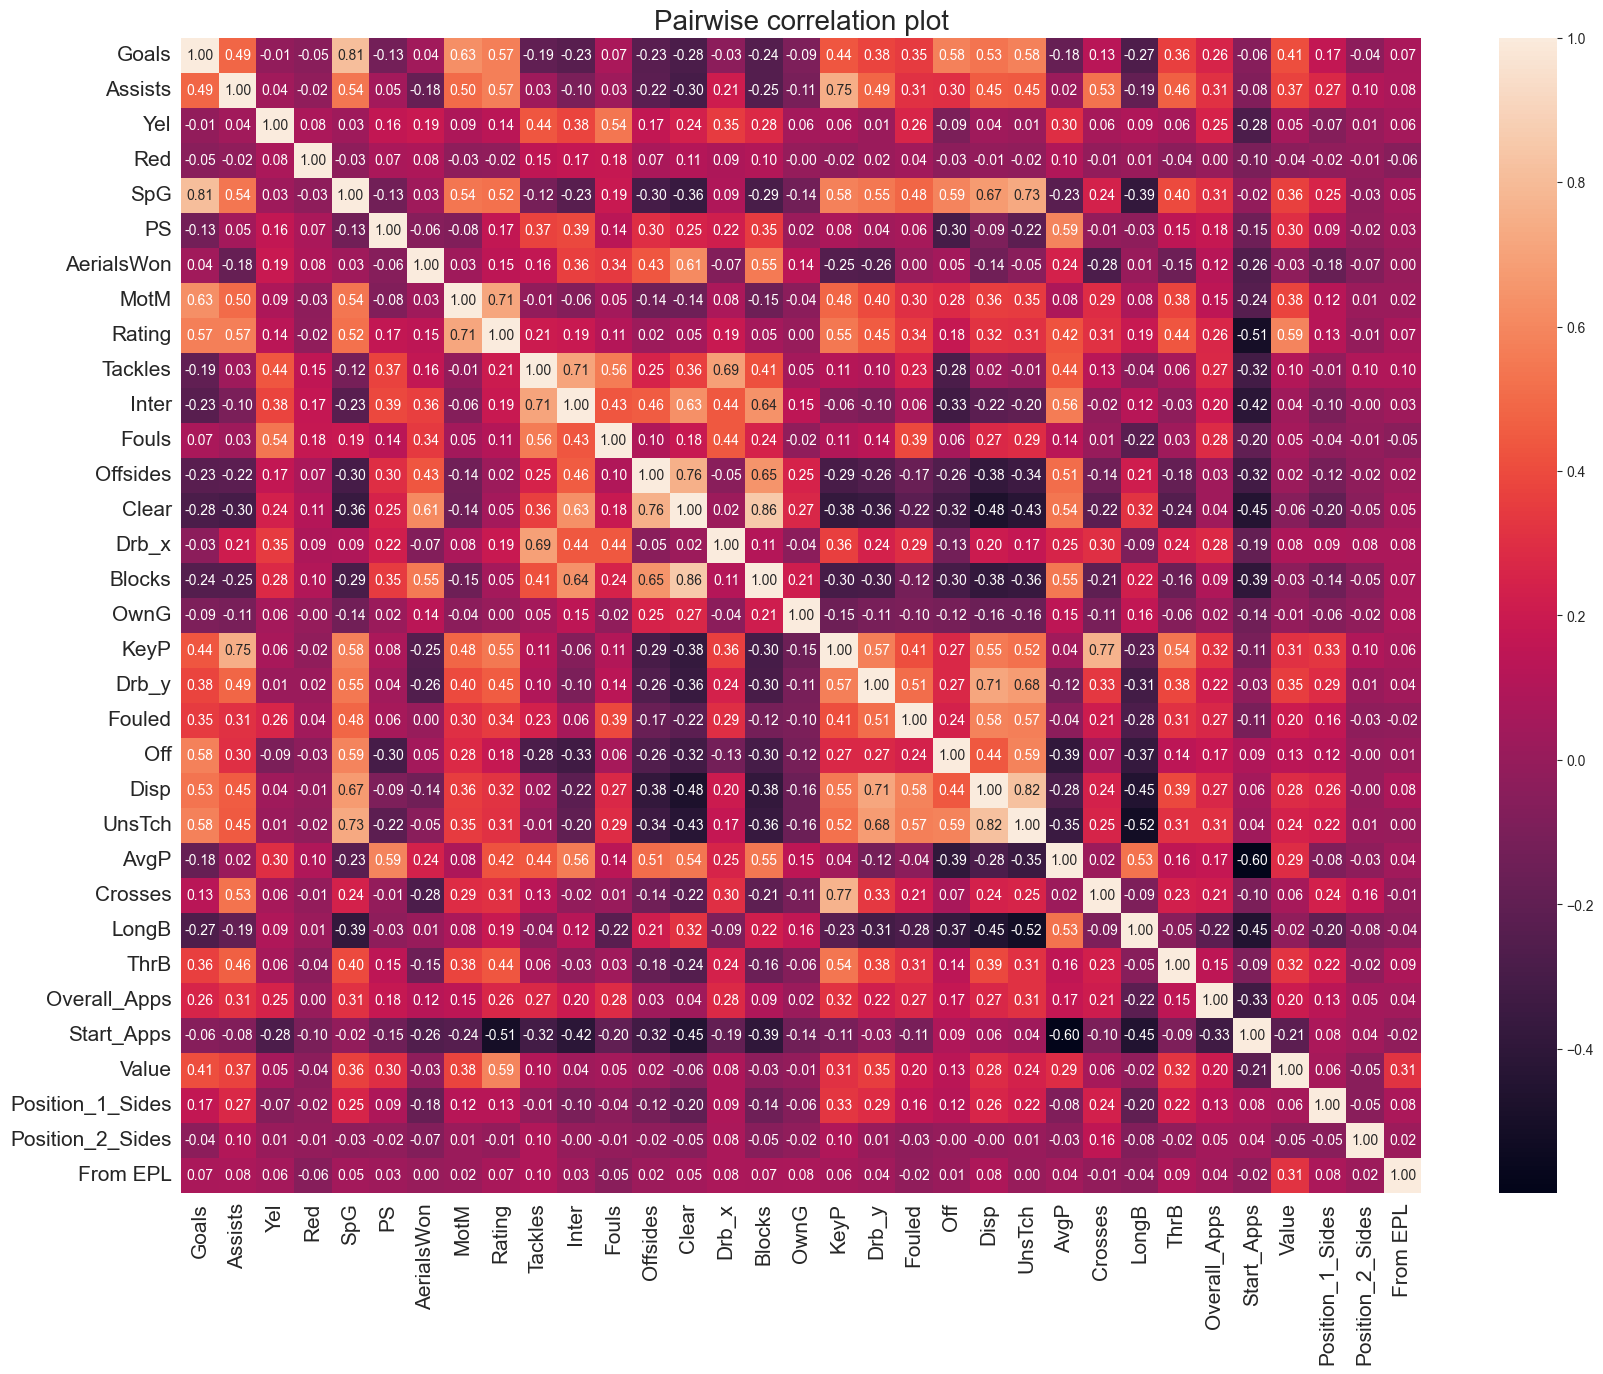

In [1450]:
corr_table = df_train.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(20, 15))

sns.heatmap(corr_table,
            annot=True,
            fmt='.2f',
            ax=ax)

ax.set_title('Pairwise correlation plot', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

Let`s check the variance of some variables and use filter methods of feature selection

In [43]:
low_variance_correlation = []

for item in all_data.columns:
    if (all_data[item].dtype == 'int64' or all_data[item].dtype == 'float') and not item.startswith('Minutes'):
        print(f'Variable: {item}')
        variance = all_data[item].values.var()
        correlation = np.corrcoef(all_data[item].values, all_data['Value'].values)[0][1]
        print(f'Its variance: {variance}')
        print(f'Its correlation with the target variable: {correlation}')
        print('=' * 25)
        
        if variance < 0.2 and correlation < 0.1:
            low_variance_correlation.append(item)

Variable: Yel
Its variance: 7.195602640206583
Its correlation with the target variable: 0.06957791237905439
Variable: Red
Its variance: 0.1726041748601323
Its correlation with the target variable: 0.027040971935954745
Variable: SpG
Its variance: 0.4794169488008114
Its correlation with the target variable: 0.16691505031827641
Variable: PS
Its variance: 62.81102228092695
Its correlation with the target variable: 0.05906579251215728
Variable: AerialsWon
Its variance: 0.726867085112187
Its correlation with the target variable: 0.01367143777859604
Variable: MotM
Its variance: 2.142786793611691
Its correlation with the target variable: 0.14323587028065213
Variable: Rating
Its variance: 0.07274254772571709
Its correlation with the target variable: 0.21003239141198282
Variable: Tackles
Its variance: 0.44861280791392555
Its correlation with the target variable: 0.00277650695005056
Variable: Inter
Its variance: 0.1888183502390679
Its correlation with the target variable: -0.0009715293308426085
V

In [44]:
all_data.drop(low_variance_correlation, axis=1, inplace=True)

In [1311]:
all_data.sample(5)

,Age,Mins,Goals,Assists,Yel,SpG,PS,AerialsWon,MotM,Rating,...,LongB,ThrB,Overall_Apps,Start_Apps,Main side,Position_1_Sides,Team_rank,From EPL,Position,Value
361,"(22.0, 28.0]","(1376.25, 1913.0]","(-0.036, 9.0]","(-0.014, 3.5]",5,0.3,88.3,2.2,0,6.57,...,1.6,0.0,21,1,C,1,C-tier,False,Defence,15.830414
494,"(22.0, 28.0]","(194.999, 1376.25]","(-0.036, 9.0]","(-0.014, 3.5]",1,0.5,73.5,0.8,0,6.38,...,0.7,0.0,11,12,C,1,C-tier,False,Midfield,14.220976
844,"(22.0, 28.0]","(2485.0, 3420.0]","(-0.036, 9.0]","(-0.014, 3.5]",7,1.1,82.8,0.7,0,6.84,...,1.2,0.1,34,3,C,2,B-tier,True,Midfield,16.906553
459,"(34.0, 40.0]","(194.999, 1376.25]","(-0.036, 9.0]","(-0.014, 3.5]",4,0.6,86.5,0.7,0,6.49,...,2.5,0.0,17,4,C,1,C-tier,False,Defence,13.458837
376,"(15.976, 22.0]","(2485.0, 3420.0]","(-0.036, 9.0]","(-0.014, 3.5]",9,0.8,81.3,5.2,2,7.04,...,1.8,0.0,31,2,C,2,C-tier,False,Defence,16.300417


In [45]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Age                  1546 non-null   category
 1   Mins                 1546 non-null   category
 2   Goals                1546 non-null   category
 3   Assists              1546 non-null   category
 4   Yel                  1546 non-null   int64   
 5   SpG                  1546 non-null   float64 
 6   PS                   1546 non-null   float64 
 7   AerialsWon           1546 non-null   float64 
 8   MotM                 1546 non-null   int64   
 9   Rating               1546 non-null   float64 
 10  Tackles              1546 non-null   float64 
 11  Clear                1546 non-null   float64 
 12  KeyP                 1546 non-null   float64 
 13  Drb_y                1546 non-null   float64 
 14  Fouled               1546 non-null   float64 
 15  Off                  

In [46]:
all_data.columns

Index(['Age', 'Mins', 'Goals', 'Assists', 'Yel', 'SpG', 'PS', 'AerialsWon',
       'MotM', 'Rating', 'Tackles', 'Clear', 'KeyP', 'Drb_y', 'Fouled', 'Off',
       'Disp', 'UnsTch', 'AvgP', 'LongB', 'ThrB', 'Overall_Apps', 'Start_Apps',
       'Main side', 'Position_1_Sides', 'Team_rank', 'European tournament',
       'From EPL', 'Position', 'Value'],
      dtype='object')

In [1314]:
all_data.sample(5)

,Age,Mins,Goals,Assists,Yel,SpG,PS,AerialsWon,MotM,Rating,...,LongB,ThrB,Overall_Apps,Start_Apps,Main side,Position_1_Sides,Team_rank,From EPL,Position,Value
532,"(28.0, 34.0]","(1376.25, 1913.0]","(-0.036, 9.0]","(-0.014, 3.5]",8,1.0,85.6,0.6,1,6.83,...,0.9,0.0,24,1,C,1,B-tier,True,Midfield,14.914123
857,"(28.0, 34.0]","(194.999, 1376.25]","(-0.036, 9.0]","(-0.014, 3.5]",3,2.0,66.5,1.2,0,6.47,...,0.4,0.0,6,13,C,1,C-tier,False,Attack,14.220976
156,"(22.0, 28.0]","(2485.0, 3420.0]","(-0.036, 9.0]","(-0.014, 3.5]",2,0.0,55.1,0.2,3,6.65,...,9.8,0.0,3,3,C,1,C-tier,False,Goalkeeper,16.118096
177,"(28.0, 34.0]","(2485.0, 3420.0]","(-0.036, 9.0]","(3.5, 7.0]",7,1.0,84.6,0.8,4,7.09,...,2.2,0.1,29,3,L,2,A-tier,False,Defence,17.034386
1338,"(15.976, 22.0]","(1376.25, 1913.0]","(-0.036, 9.0]","(-0.014, 3.5]",1,1.3,72.5,0.5,0,6.55,...,0.5,0.0,20,9,L,2,B-tier,False,Midfield,16.811243


In [47]:
exclude_feats = ['Age', 'Mins', 'Goals', 'Assists', 'From EPL', 'Value']

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_feats = list(set(numeric_feats.to_list()) - set(exclude_feats))

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
Off,2.357978
LongB,2.299922
ThrB,2.259787
MotM,2.105390
AerialsWon,1.969692
Drb_y,1.923106
KeyP,1.476544
Clear,1.468366
SpG,1.249643
Start_Apps,1.038115


In [48]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.01
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 20 skewed numerical features to Box Cox transform


In [49]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_feats = list(set(numeric_feats.to_list()) - set(exclude_feats))

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
ThrB,1.940648
Off,1.808462
Drb_y,0.891434
Position_1_Sides,0.770752
AerialsWon,0.770627
MotM,0.745534
Clear,0.671071
LongB,0.671000
Rating,0.650554
KeyP,0.565294


**Feature transformation**

In [50]:
label_encoding = ['Age', 'Mins', 'Goals', 'Assists', 'Main side', 'Team_rank', 'Position', 'European tournament']
one_hot_encoding = ['Main side', 'Position']

In [51]:
label_enc = LabelEncoder()

for label in label_encoding:
    all_data[label] = label_enc.fit_transform(all_data[label])

In [52]:
all_data = pd.get_dummies(all_data, columns=one_hot_encoding, drop_first=True)

In [53]:
df_train, df_test = divide_df(all_data)

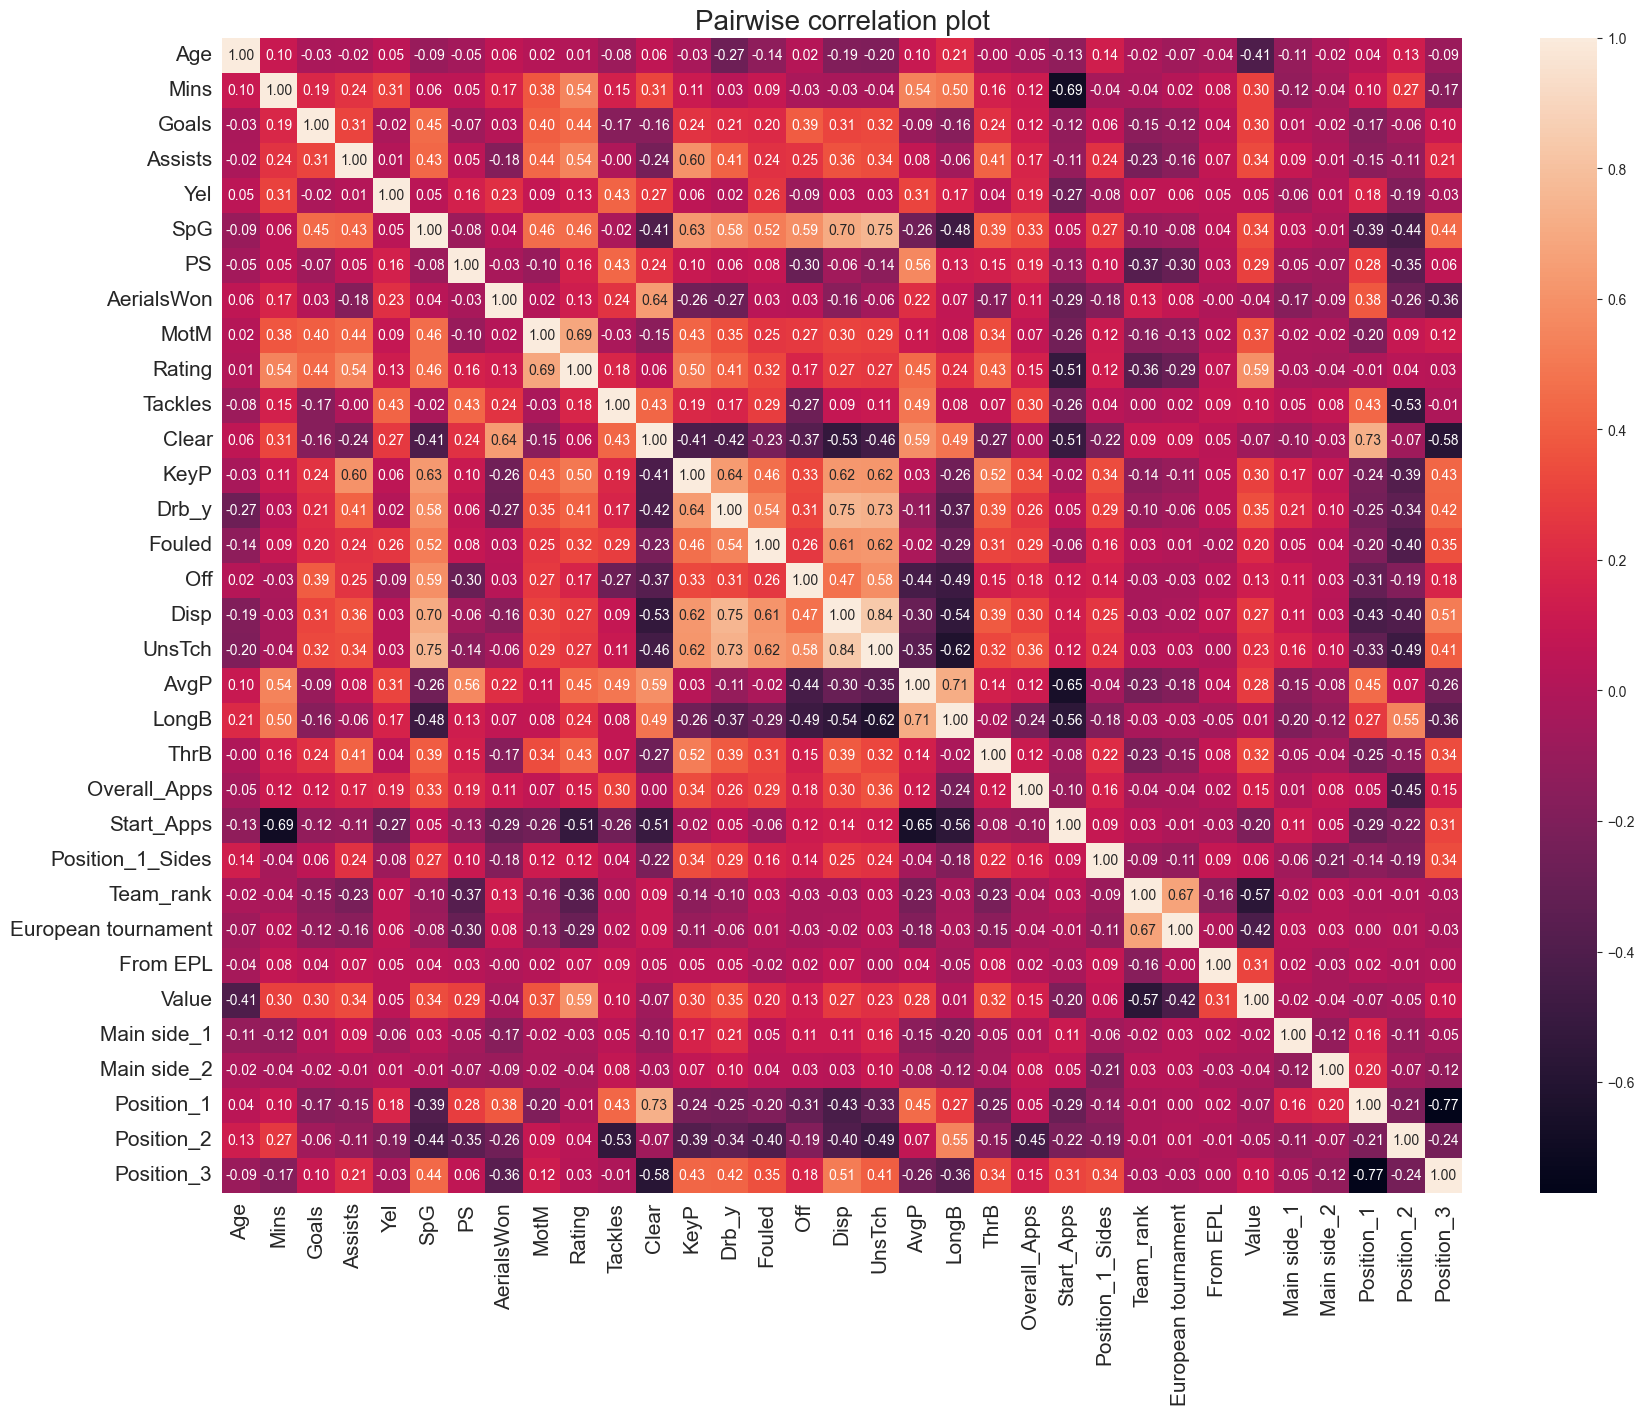

In [54]:
corr_table = df_train.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(20, 15))

sns.heatmap(corr_table,
            annot=True,
            fmt='.2f',
            ax=ax)

ax.set_title('Pairwise correlation plot', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

**3. LEARNING A MODEL**

This section will be divided into 3 parts. In the first part we will create the DecisionTree model to see how it makes decisions on the data and how well it performs. In the next part we will examine all the basic machine learning models in order to choose the best one. In the final part we will choose one of the algorithms and learn it via GridSearch with a larger hyperparameters grid 

In [ ]:
# We use embedded method (ExtraTrees -> feature_importances_) and drop some other variables:
#all_data.drop(['Start_Apps', 'LongB', 'Yel', 'Drb_y', 'Tackles',
#               'Position_1_Sides', 'Clear', 'Assists', 'Position_3',
#               'Position_1', 'Main side_1', 'Position_2', 'Main side_2'], axis=1, inplace=True)

In [55]:
df_train, df_test = divide_df(all_data)

X_train, y_train = df_train.drop('Value', axis=1), df_train['Value']
X_test, y_test = df_test.drop('Value', axis=1), df_test['Value']

feature_names = X_train.columns

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

*1. Decision Tree*

In this part we will create a basic decision tree and then visualize it. This model is good at representativeness and interpretability so we must know how to deal with it

In [ ]:
# Train a basic model - without any hyperparameter fine-tuning
basic_decision_tree = DecisionTreeRegressor()

In [ ]:
basic_decision_tree.fit(X_train, y_train)

In [56]:
def regression_metrics(prediction, reality):
    print(f'RMSE: {root_mean_squared_error(prediction, reality)}')
    print(f'log RMSE: {root_mean_squared_log_error(np.abs(prediction), reality)}')
    print(f'MAPE: {mean_absolute_percentage_error(prediction, reality)}')
    print(f'R2 score: {r2_score(prediction, reality)}')
    
def show_predictions(model):
    answers = pd.DataFrame([test_names.values, y_test.values, np.expm1(pd.Series(model.predict(X_test)).values)]).T
    answers.rename(columns={0: 'Name', 1: 'Test value', 2: 'Predicted value'}, inplace=True)
    
    return answers

def show_importances(features, model):
    feature_importances = pd.DataFrame(model.feature_importances_, index=features, columns=['Importance'])
    feature_importances.sort_values(by='Importance', ascending=False, inplace=True)
    
    return feature_importances

In [1465]:
regression_metrics(basic_decision_tree.predict(X_train), y_train)

RMSE: 24679715.925542593
log RMSE: 13.144453536114447
MAPE: 0.9999964343124353
R2 score: -0.6497801248401169


In [1466]:
regression_metrics(basic_decision_tree.predict(X_test), y_test)

RMSE: 15787161.740048515
log RMSE: 0.8381772806367119
MAPE: 0.818855029905789
R2 score: 0.3777378204546451


In [ ]:
display(show_predictions(basic_decision_tree).sample(5))

We see that this model expectedly overfits the data. Let`s somehow adjust our algorithm

In [ ]:
vis_decision_tree = DecisionTreeRegressor(max_depth=3)

In [ ]:
vis_decision_tree.fit(X_train, y_train)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

plot_tree(vis_decision_tree, feature_names=feature_names, filled=True, fontsize=8)

plt.show()

In [ ]:
display(show_importances(feature_names, vis_decision_tree).head(8))

The basic decision tree with max_depth = 3 makes its decisions based mainly on the rating, rank of the team in which a footballer plays and his age. So our new feature 'Team_rank' is very important for this ML algorithm. Let`s check the same thing for the first tree

In [ ]:
display(show_importances(feature_names, basic_decision_tree))

In [ ]:
regression_metrics(vis_decision_tree.predict(X_train), y_train)

In [ ]:
regression_metrics(vis_decision_tree.predict(X_test), y_test)

This model has problem with underfitting the data. So let`s use the RandomizedSearch algorithm in order to get the best possible tree. It will be faster than usual GridSearch and may give better performance.

In [ ]:
decision_tree_param_grid = {
    'max_depth': [1, 3, 5, 7, 11, 13, 15],
    'min_samples_split': sp_randint(2, 16),
    'min_samples_leaf': sp_randint(2, 16)
}

In [ ]:
tune_decision_tree = RandomizedSearchCV(DecisionTreeRegressor(), decision_tree_param_grid, n_iter=300, cv=5, random_state=42)
tune_decision_tree.fit(X_train, y_train)

In [ ]:
best_decision_tree = tune_decision_tree.best_estimator_

In [ ]:
best_decision_tree.fit(X_train, y_train)

In [ ]:
show_importances(feature_names, best_decision_tree)

In [ ]:
regression_metrics(best_decision_tree.predict(X_train), y_train)

In [ ]:
regression_metrics(best_decision_tree.predict(X_test), y_test)

In [ ]:
display(show_predictions(best_decision_tree).sample(10))

This model performs better. But we see that it shows poor performance and doesn't use all the features we have. Let's check other ML algorithms and choose the best one

*2. Choosing a model*

In [1467]:
all_models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    BaggingRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(),
    ExtraTreesRegressor(),
    
    SVR(),
    NuSVR(),
    
    LinearRegression(),
    SGDRegressor(),
    Ridge(), 
    Lasso(), 
    ElasticNet(), 
    BayesianRidge()
]

In [1468]:
cv_splits = KFold(n_splits=5, shuffle=True)

scores_table = pd.DataFrame(columns=['train RMSE', 'test RMSE', 'train RMSE 3std', 'test RMSE 3std'])
predictions_table = pd.DataFrame(y_train, index=y_train.index)

for alg in all_models:
    alg_name = alg.__class__.__name__
    
    cv_results = cross_validate(alg, 
                                X_train, 
                                y_train,
                                cv=cv_splits,
                                scoring='neg_root_mean_squared_error',
                                return_train_score=True)
    
    scores_table.loc[alg_name, 'train RMSE'] = -cv_results['train_score'].mean()
    scores_table.loc[alg_name, 'test RMSE'] = -cv_results['test_score'].mean()
    #scores_table.loc[alg_name, 'train R2'] = cv_results['train_score'].mean()
    #scores_table.loc[alg_name, 'test R2'] = cv_results['test_score'].mean()
    
    scores_table.loc[alg_name, 'train RMSE 3std'] = cv_results['train_score'].std()*3
    scores_table.loc[alg_name, 'test RMSE 3std'] = cv_results['test_score'].std()*3
    #scores_table.loc[alg_name, 'train R2 3std'] = cv_results['train_score'].std()*3
    #scores_table.loc[alg_name, 'test R2 3std'] = cv_results['test_score'].std()*3
    
    alg.fit(X_train, y_train)
    
    predictions_table.loc[:, alg_name] = alg.predict(X_train)
    
scores_table.sort_values(by='test RMSE', ascending=True, inplace=True)

In [1469]:
display(scores_table)

,train RMSE,test RMSE,train RMSE 3std,test RMSE 3std
BayesianRidge,0.60061,0.61498,0.040802,0.163898
LinearRegression,0.600043,0.617376,0.033331,0.132893
Ridge,0.599983,0.617717,0.034132,0.138409
GradientBoostingRegressor,0.451954,0.619041,0.016827,0.094609
SGDRegressor,0.602745,0.620428,0.04194,0.160858
ExtraTreesRegressor,0.0,0.639304,0.0,0.060011
SVR,0.479443,0.640439,0.030085,0.080462
RandomForestRegressor,0.241085,0.648914,0.011103,0.119785
NuSVR,0.492186,0.649661,0.025454,0.08935
XGBRegressor,0.02414,0.669857,0.005623,0.073295


We see that the best performance show ensemble and boosting methods like Gradient Boosting or Random Forest, but we also can notice that SVM algorithm obviously has an underfitting problem, so we can try to somehow fine-tune it (using kernels or adjusting the values of hyperparameters). But now we will try to use the RandomForestRegressor and find the best values of hyperparameters via GridSearchCV.

In [ ]:
random_forest_grid = {
    'max_depth': range(5, 14, 2),
    'min_samples_split': range(2, 11, 2),
    'min_samples_leaf': range(1, 11, 2),
    'max_features': np.arange(0.6, 1.1, 1),
    'n_estimators': [100]
}

In [ ]:
tune_random_forest = GridSearchCV(RandomForestRegressor(), random_forest_grid)
tune_random_forest.fit(X_train, y_train)

In [ ]:
best_random_forest = RandomForestRegressor(n_estimators=1000,
                                           max_depth=9,
                                           max_features=0.6,
                                           min_samples_leaf=4,
                                           min_samples_split=8)

In [ ]:
best_random_forest.fit(X_train, y_train)

In [ ]:
regression_metrics(best_random_forest.predict(X_train), y_train)

In [ ]:
regression_metrics(best_random_forest.predict(X_test), y_test)

In [ ]:
show_predictions(best_random_forest)

In [ ]:
basic_random_forest = RandomForestRegressor()
basic_random_forest.fit(X_train, y_train)

In [57]:
extra_grid_params = {
    'max_depth': [5, 7, 9, 11, 13, 15, 17, 19, 21],
    'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14]
}

In [58]:
tune_extra_trees = GridSearchCV(ExtraTreesRegressor(), extra_grid_params, scoring='r2', cv=5)
tune_extra_trees.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(),
             param_grid={'max_depth': [5, 7, 9, 11, 13, 15, 17, 19, 21],
                         'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14]},
             scoring='r2')

In [59]:
best_extra_trees = tune_extra_trees.best_estimator_
best_extra_trees.fit(X_train, y_train)

ExtraTreesRegressor(max_depth=19, min_samples_leaf=6)

In [60]:
best_extra_trees = ExtraTreesRegressor(max_depth=19, min_samples_leaf=6, n_estimators=10000)
best_extra_trees.fit(X_train, y_train)

ExtraTreesRegressor(max_depth=19, min_samples_leaf=6, n_estimators=10000)

In [61]:
regression_metrics(best_extra_trees.predict(X_train), y_train)
print('=' * 25)
regression_metrics(np.expm1(best_extra_trees.predict(X_test)), y_test)

RMSE: 0.4315228525158853
log RMSE: 0.026447060409343703
MAPE: 0.020902238369853256
R2 score: 0.828140086082584
RMSE: 10648728.159708492
log RMSE: 0.5636880241969502
MAPE: 0.45716481542237475
R2 score: 0.4101421329704462


In [62]:
show_importances(feature_names, best_extra_trees)

,Importance
Team_rank,0.381873
Age,0.253769
Rating,0.131250
From EPL,0.058753
Mins,0.048205
MotM,0.016765
SpG,0.011625
European tournament,0.009767
ThrB,0.008044
Disp,0.005283


In [65]:
a = show_predictions(best_extra_trees)
display(a.sample(20))

,Name,Test value,Predicted value
64,Luca Waldschmidt,2500000.0,4715375.744342
141,Max Wöber,10000000.0,15774538.173756
276,Emmanuel Sabbi,2500000.0,3745198.074045
39,Jacob Murphy,15000000.0,9231603.298878
169,Savinho,50000000.0,32979319.454552
101,Abdul Mumin,2500000.0,3609822.867251
33,Marten de Roon,7000000.0,8254041.710154
104,Kingsley Ehizibue,2200000.0,1532436.284201
224,Mathys Tel,40000000.0,28104195.441911
197,Laurent Abergel,3000000.0,7388439.178362


In [ ]:
xgboost_grid_params = {
    'eta': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_depth': [1, 3, 5, 7, 9, 11],
    'n_estimators': [100, 300, 500],
    'gamma': [0, 0.1, 1, 10, 100]
}

In [ ]:
tune_xgboost_regressor = GridSearchCV(XGBRegressor(), xgboost_grid_params, scoring='r2', cv=5)
tune_xgboost_regressor.fit(X_train, y_train)

In [ ]:
best_xgboost_regressor = tune_xgboost_regressor.best_estimator_
best_xgboost_regressor.fit(X_train, y_train)

In [ ]:
regression_metrics(best_xgboost_regressor.predict(X_train), y_train)

In [ ]:
regression_metrics(best_xgboost_regressor.predict(X_test), y_test)

In [ ]:
pred = show_predictions(best_xgboost_regressor)

In [ ]:
pred[pred['Test value'] > 50000000]

In [ ]:
linear_grid_params = {
    'alpha': [44, 45, 46, 47, 48, 49, 50, 51, 52, 53],
}

In [ ]:
fine_ridge_regressor = GridSearchCV(Ridge(), ridge_grid_params, scoring='neg_mean_squared_error', cv=5)
fine_ridge_regressor.fit(X_train, y_train)

In [ ]:
best_ridge_regressor = fine_ridge_regressor.best_estimator_
best_ridge_regressor.fit(X_train, y_train)

In [ ]:
regression_metrics(best_ridge_regressor.predict(X_train), y_train)
regression_metrics(best_ridge_regressor.predict(X_test), y_test)

In [ ]:
display(predictions_table)